# Importing Libraries and Downloading Data

In [21]:
! pip install wandb

#### Import libraries

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import mnist, fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")
import wandb
import seaborn as sns

#### Download data

In [23]:
(X, y), (X_test, y_test) = fashion_mnist.load_data()

# Reshaping the data matrices
X = X.reshape(X.shape[0], 784)
X_test = X_test.reshape(X_test.shape[0], 784)

# Normalizing the pixel intensities
X = X/255.0
X_test = X_test/255.0

# Split the X_train into a training set and validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Dataset Preprocessing

In [24]:
# Number of training examples
M = X_train.shape[0]

# Number of validation samples
Mval = X_val.shape[0]

# Number of test examples
Mtest = X_test.shape[0]

# Number of features in the dataset
num_features = 784

# Number of classes
num_classes = len(np.unique(y_train))

# One hot encoding for class labels
y_train_one_hot = np.zeros((10, M))
y_train_one_hot[y_train, np.array(list(range(M)))] = 1

y_val_one_hot = np.zeros((10, Mval))
y_val_one_hot[y_val, np.array(list(range(Mval)))] = 1

y_test_one_hot = np.zeros((10, Mtest))
y_test_one_hot[y_test, np.array(list(range(Mtest)))] = 1

print("Number of images in the training set =", M)
print("Number of images in the validation set =", Mval)
print("Number of images in the test set =", Mtest)
print("Number of classes =", num_classes)
print("Number of features per example =", num_features)

Number of images in the training set = 54000
Number of images in the validation set = 6000
Number of images in the test set = 10000
Number of classes = 10
Number of features per example = 784


In [25]:
# Modify shapes of the data matrices
X_train = X_train.T
X_val = X_val.T
X_test = X_test.T
X = X.T

#### Number of neurons in the input and output layers

In [26]:
input_nodes = num_features
output_nodes = num_classes

#### Class names

In [27]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#### Logging Sample Images

In [49]:
wandb.init(project="dl_assignment1", entity="ee17b154tony", name="assignment_1_log_images")

# Store the index of first occurrence of each class
example_indices = [list(y_train).index(i) for i in range(num_classes)]

# example_images is a list containing one sample image per class, example_captions stores the corresponsing captions
example_images = []
example_captions = []
for index in example_indices:
    example_images.append(X_train.T[index].reshape((28, 28)))
    example_captions.append(class_names[y_train[index]])

# Log one sample image of each class to wandb
wandb.log({"Sample Image from each class": [wandb.Image(image, caption=caption) for image, caption in zip(example_images, example_captions)]})

wandb: WARNING Ignored wandb.init() arg project when running a sweep
wandb: WARNING Ignored wandb.init() arg entity when running a sweep


# Components of the Neural Network Model

#### Activation functions and their derivatives

In [30]:
def sigmoid(x):
    return 1. / (1.+np.exp(-x))

def sigmoid_derivative(x):
    return sigmoid(x) * (1-sigmoid(x))

def Relu(x):
    return np.maximum(0,x)

def Relu_derivative(x):
    return 1*(x>0) 

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return (1 - (np.tanh(x)**2))

def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def softmax_derivative(x):
    return softmax(x) * (1-softmax(x))

#cross-entropy for our cost function
def compute_multiclass_loss(Y, Y_hat, batch_size, loss, lamb, parameters):

    if loss == 'categorical_crossentropy':
         L = (-1.0 * np.sum(np.multiply(Y, np.log(Y_hat))))/batch_size
    elif loss == 'mse':
         L = (1/2) * np.sum((Y-Y_hat)**2)/batch_size

    acc = 0
    for i in range(1, len(parameters)//2 + 1):
        acc += np.sum(parameters["W"+str(i)]**2)

    L = L + (lamb/(2*batch_size))*acc

    return L

#### Initialize parameters

In [32]:
def initialize_parameters(layer_dims, init_mode="xavier"):
    np.random.seed(42)
    params = {}
    previous_updates = {}
    for i in range(1, len(layer_dims)):
        if init_mode == 'random_normal':
            params["W"+str(i)] = np.random.randn(layer_dims[i], layer_dims[i-1]) * 0.01
        elif init_mode == 'random_uniform':
            params["W"+str(i)] = np.random.rand(layer_dims[i], layer_dims[i-1]) * 0.01
        elif init_mode == 'xavier':
            params["W"+str(i)]= np.random.randn(layer_dims[i],layer_dims[i-1])*np.sqrt(2/(layer_dims[i]+layer_dims[i-1]))
            
        params["b"+str(i)] = np.zeros((layer_dims[i], 1))
        
        previous_updates["W"+str(i)] = np.zeros((layer_dims[i], layer_dims[i-1]))
        previous_updates["b"+str(i)] = np.zeros((layer_dims[i], 1))

    return params,previous_updates

#### Forward Propagation

In [33]:
def forward_propagate(X, params, activation_f):
    L = len(params)//2 + 1
    A = [None]*L # activations
    Z = [None]*L # pre-activations
    
    A[0] = X
    
    for l in range(1, L):
        W = params["W"+str(l)]
        b = params["b"+str(l)]
        
        Z[l] = np.matmul(W,A[l-1]) + b
        
        if l == L-1:
            A[l] = softmax(Z[l]) # activation function for output layer
        else:
            if activation_f == 'sigmoid':
                A[l] = sigmoid(Z[l])
            elif activation_f == 'relu':
                A[l] = Relu(Z[l])
            elif activation_f == 'tanh':
                A[l] = tanh(Z[l])
                
    output = A[L-1]

    return output,A,Z

#### Backpropagation

In [34]:
def backprop(y_hat, y,A, Z, params, activation_f, batch_size, loss, lamb):
    L = len(params)//2
    gradients = {}
    
    if loss == 'categorical_crossentropy':
        gradients["dZ"+str(L)] = A[L]-y
    elif loss == 'mse':
        gradients["dZ"+str(L)] = (A[L]-y) * softmax_derivative(Z[L])
    
    for l in range(L,0,-1):
        gradients["dW" + str(l)] = (np.dot(gradients["dZ" + str(l)], A[l-1].T) + lamb*params["W"+str(l)]) / batch_size
        gradients["db" + str(l)] = np.sum(gradients["dZ" + str(l)], axis=1, keepdims=True) / batch_size
        
        if l>1:
            if activation_f == 'sigmoid':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * sigmoid_derivative(Z[l-1])
            elif activation_f == 'relu':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * Relu_derivative(Z[l-1])
            elif activation_f == 'tanh':
                gradients["dZ"+str(l-1)] = np.matmul(params["W" + str(l)].T, gradients["dZ" + str(l)]) * tanh_derivative(Z[l-1])
        
    return gradients

#### Optimizers

This block contains functions that implement stochastic gradient descent, momentum, RMSprop, Adam. Nadam and Nestorov accelerated gradient are implemented inside the NN_fit function.

In [35]:
def update_params_sgd(parameters,grads,learning_rate):
    L = len(parameters) // 2 
    
    for l in range(1, L + 1):
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]

    return parameters

def update_parameters_momentum(parameters, grads, learning_rate, beta, previous_updates):
    L = len(parameters) // 2 # number of layers in the neural network

    for l in range(1, L + 1):
        previous_updates["W"+str(l)] = beta*previous_updates["W"+str(l)] + (1-beta)*grads["dW" + str(l)]
        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate*previous_updates["W"+str(l)]
        
        previous_updates["b"+str(l)] = beta*previous_updates["b"+str(l)] + (1-beta)*grads["db" + str(l)]
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate*previous_updates["b"+str(l)]

    return parameters, previous_updates
    
def update_parameters_RMSprop(parameters, grads, learning_rate, beta, v):

    L = len(parameters) // 2 # number of layers in the neural network
    delta = 1e-6 # for numerical stability

    for l in range(1, L + 1):
        vdw = beta*v["W" + str(l)] + (1-beta)*np.multiply(grads["dW" + str(l)],grads["dW" + str(l)])
        vdb = beta*v["b" + str(l)] + (1-beta)*np.multiply(grads["db" + str(l)],grads["db" + str(l)])

        parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)] / (np.sqrt(vdw)+delta)
        parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)] / (np.sqrt(vdb)+delta)

        v["W" + str(l)] = vdw
        v["b" + str(l)] = vdb

    return parameters,v

def update_parameters_adam(parameters, grads, learning_rate, v, m, t):
    L = len(parameters) // 2 # number of layers in the neural network
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 1e-8

    for l in range(1, L+1):
        mdw = beta1*m["W"+str(l)] + (1-beta1)*grads["dW"+str(l)]
        vdw = beta2*v["W"+str(l)] + (1-beta2)*np.square(grads["dW"+str(l)])
        mw_hat = mdw/(1.0 - beta1**t)
        vw_hat = vdw/(1.0 - beta2**t)

        parameters["W"+str(l)] = parameters["W"+str(l)] - (learning_rate * mw_hat)/np.sqrt(vw_hat + epsilon)

        mdb = beta1*m["b"+str(l)] + (1-beta1)*grads["db"+str(l)]
        vdb = beta2*v["b"+str(l)] + (1-beta2)*np.square(grads["db"+str(l)])
        mb_hat = mdb/(1.0 - beta1**t)
        vb_hat = vdb/(1.0 - beta2**t)

        parameters["b"+str(l)] = parameters["b"+str(l)] - (learning_rate * mb_hat)/np.sqrt(vb_hat + epsilon)

        v["dW"+str(l)] = vdw
        m["dW"+str(l)] = mdw
        v["db"+str(l)] = vdb
        m["db"+str(l)] = mdb

    t = t + 1 # timestep
    return parameters, v, m, t

#### Function to plot the cost curves

In [36]:
def plot_cost_curve(train_costs, val_costs):
    plt.plot(list(range(len(train_costs))), train_costs, 'r', label="Training loss")
    plt.plot(list(range(len(val_costs))), val_costs, 'lime', label="Validation loss")
    plt.title("Training and Validation Loss vs Number of Epochs", size=14)
    plt.xlabel("Number of epochs", size=14)
    plt.ylabel("Loss", size=14)
    plt.grid()
    plt.legend()
    plt.show()

#### Prediction and Evaluation functions

In [45]:
def NN_predict(X_test, params, activation_f):
    output, _, _ = forward_propagate(X_test, params, activation_f)
    predictions = np.argmax(output, axis=0)
    return predictions

def NN_evaluate(X_train, y_train, X_test, y_test, params, activation_f):
    train_predictions = NN_predict(X_train, params, activation_f)
    test_predictions = NN_predict(X_test, params, activation_f)

    print("Training accuracy = {} %".format(round(accuracy_score(y_train, train_predictions) * 100, 3)))
    print("Test accuracy = {} %".format(round(accuracy_score(y_test, test_predictions) * 100, 3)))

    print("Classification report for the test set:\n")
    print(classification_report(y_test, test_predictions))

    return train_predictions, test_predictions

# Hyperparameter tuning using Sweeps

In [16]:
def NN_fit():
    # Default values for hyper-parameters
    config_defaults = {
        'epochs': 10,
        'batch_size': 64,
        'learning_rate': 1e-3,
        'activation_f': 'relu',
        'optimizer': 'adam',
        'init_mode': 'xavier',
        'L2_lamb': 0,
        'num_neurons': 64,
        'num_hidden': 3
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # Local variables, values obtained from wandb config
    num_neurons = config.num_neurons
    num_hidden = config.num_hidden
    init_mode = config.init_mode
    epochs = config.epochs
    batch_size = config.batch_size
    learning_rate = config.learning_rate
    activation_f = config.activation_f
    L2_lamb = config.L2_lamb
    optimizer = config.optimizer

    # Display the hyperparameters
    run_name = "lr_{}_ac_{}_in_{}_op_{}_bs_{}_L2_{}_ep_{}_nn_{}_nh_{}".format(learning_rate, activation_f, init_mode, optimizer, batch_size, L2_lamb, epochs, num_neurons, num_hidden)
    print(run_name)

    #Layer sizes
    layer_dims = [num_features] + [num_neurons]*num_hidden + [num_classes]

    params, previous_updates = initialize_parameters(layer_dims, init_mode) # initialize the parameters and past updates matrices
    
    epoch_cost = []
    validation_epoch_cost = []
    
    count = 1
    t = 1 # initialize timestep for Adam optimizer
    v = previous_updates.copy()
    m = previous_updates.copy()
    params_look_ahead = params.copy() # initialization for nestorov
    beta = 0.9
    loss = 'categorical_crossentropy'    

    while count<=epochs:
        count = count + 1 # increment the number of epochs
        for i in range(0, X_train.shape[1], batch_size):
            batch_count = batch_size
            if i + batch_size > X_train.shape[1]: # the last mini-batch might contain fewer than "batch_size" examples
                batch_count = X_train.shape[1] - i + 1

            if optimizer == 'nesterov':
                L = len(params)//2
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]
                    
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, loss, L2_lamb)
                params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                
            elif optimizer=='nadam':
                L = len(params)//2
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]

                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, loss, L2_lamb)
                params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)

            else:
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params,activation_f, batch_count, loss, L2_lamb)

                if optimizer == 'sgd':
                    params = update_params_sgd(params,gradients,learning_rate)
                elif optimizer == 'momentum':
                    params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'RMSprop':
                    params,previous_updates = update_parameters_RMSprop(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'adam':
                    params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)

        # Mean loss for the full training set
        full_output, _, _ = forward_propagate(X_train, params, activation_f)
        cost = compute_multiclass_loss(y_train_one_hot, full_output, M, loss, L2_lamb, params)
        epoch_cost.append(cost)
        
        # Mean loss for the validation set
        out, _, _ = forward_propagate(X_val, params, activation_f)
        val_cost = compute_multiclass_loss(y_val_one_hot, out, Mval, loss, L2_lamb, params)
        validation_epoch_cost.append(val_cost)

        # Training accuracy at the end of the epoch
        train_predictions = NN_predict(X_train, params, activation_f)
        train_acc = accuracy_score(y_train, train_predictions)

        # Validation accuracy at the end of the epoch
        val_predictions = NN_predict(X_val, params, activation_f)
        val_acc = accuracy_score(y_val, val_predictions)

        wandb.log({"training_acc": train_acc, "validation_accuracy": val_acc, "training_loss": cost, "validation cost": val_cost, 'epoch': count})

        if (count % 2 == 0):
            print("Epoch number : {}".format(count))
            print("Training cost: ", cost, "\tValidation cost:",val_cost)


    print("\nFinal training cost:", cost)
    
    # Plot the training and validation cost curves
    plot_cost_curve(epoch_cost, validation_epoch_cost)

    # Meaningful name for the run
    wandb.run.name = run_name
    wandb.run.save()
    wandb.run.finish()

    
    return params, epoch_cost

#### W&B Sweep

In this cell, we set up the configurations for the various hyperparameters and use the Sweeps feature to find the combination that gives us the highest validation accuracy. 

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: llbffh9f
Sweep URL: https://wandb.ai/ee17b154tony/dl_assignment1/sweeps/llbffh9f


wandb: Agent Starting Run: ty6wriq0 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: adam
wandb: Currently logged in as: ee17b154tony (use `wandb login --relogin` to force relogin)


lr_0.0001_ac_relu_in_xavier_op_adam_bs_32_L2_0.5_ep_10_nn_64_nh_5
Epoch number : 2
Training cost:  0.6397931262109443 	Validation cost: 0.6554302074564509
Epoch number : 4
Training cost:  0.5347477082637458 	Validation cost: 0.546022324018171
Epoch number : 6
Training cost:  0.5177458970154847 	Validation cost: 0.5286709463604502
Epoch number : 8
Training cost:  0.5049558245740423 	Validation cost: 0.5171151131813032
Epoch number : 10
Training cost:  0.49135533031424194 	Validation cost: 0.5035320440410601

Final training cost: 0.48729427803132475


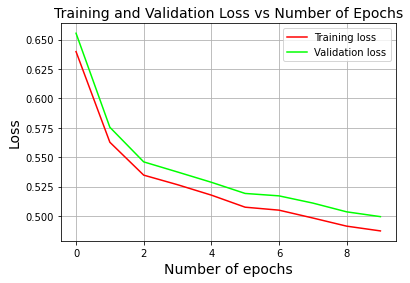

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: iexq1dn8 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: adam


lr_0.001_ac_tanh_in_random_uniform_op_adam_bs_64_L2_0.0005_ep_40_nn_128_nh_3
Epoch number : 2
Training cost:  0.7565966593021975 	Validation cost: 0.74807868419874
Epoch number : 4
Training cost:  0.5005881002474151 	Validation cost: 0.5139459715794689
Epoch number : 6
Training cost:  0.4062983156820662 	Validation cost: 0.4335950728840421
Epoch number : 8
Training cost:  0.4053557560137849 	Validation cost: 0.44873550611183416
Epoch number : 10
Training cost:  0.3532395990420967 	Validation cost: 0.4052158834713457
Epoch number : 12
Training cost:  0.3401473065683908 	Validation cost: 0.407933772709778
Epoch number : 14
Training cost:  0.30913511441087027 	Validation cost: 0.3964654380440123
Epoch number : 16
Training cost:  0.2993138780884856 	Validation cost: 0.3929893787786201
Epoch number : 18
Training cost:  0.2808112988950411 	Validation cost: 0.3949585901025209
Epoch number : 20
Training cost:  0.30224442017842773 	Validation cost: 0.42812310924601343
Epoch number : 22
Training

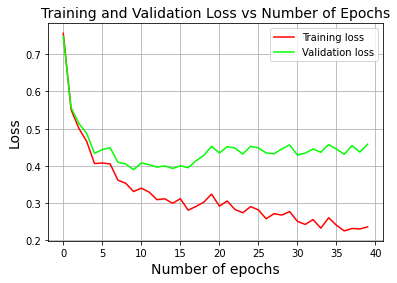

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: ycaim3jo with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: adam


lr_0.001_ac_relu_in_random_uniform_op_adam_bs_64_L2_0.5_ep_5_nn_128_nh_4
Epoch number : 2
Training cost:  1.6676063956615517 	Validation cost: 1.6618911340888987
Epoch number : 4
Training cost:  0.9350337768025233 	Validation cost: 0.9391150400957441
Epoch number : 6
Training cost:  0.9012504024653734 	Validation cost: 0.9268484016426811

Final training cost: 0.9012504024653734


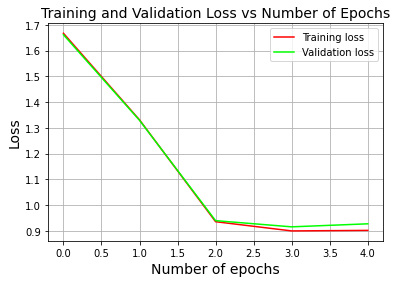

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: a48llt6v with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 512
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam


lr_0.001_ac_relu_in_random_uniform_op_nadam_bs_512_L2_0_ep_40_nn_32_nh_5
Epoch number : 2
Training cost:  2.302567416583476 	Validation cost: 2.302602528992845
Epoch number : 4
Training cost:  2.3012478112471064 	Validation cost: 2.3012652896875
Epoch number : 6
Training cost:  1.8606983421678227 	Validation cost: 1.8527418228967385
Epoch number : 8
Training cost:  1.6816778317666488 	Validation cost: 1.677653270023216
Epoch number : 10
Training cost:  1.5691296742808312 	Validation cost: 1.567418984967264
Epoch number : 12
Training cost:  1.5004295618154968 	Validation cost: 1.499431312403902
Epoch number : 14
Training cost:  1.45478117537913 	Validation cost: 1.4545902347648763
Epoch number : 16
Training cost:  1.4192082629510328 	Validation cost: 1.417634255705881
Epoch number : 18
Training cost:  1.3975068479403052 	Validation cost: 1.3973135125185228
Epoch number : 20
Training cost:  1.3697383368352765 	Validation cost: 1.3700358637792707
Epoch number : 22
Training cost:  1.350650

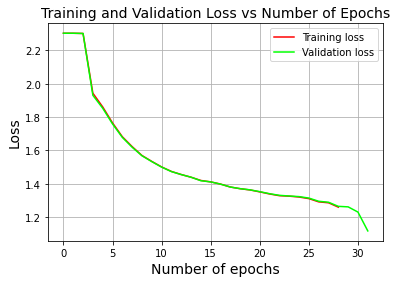

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: cbvg1oxq with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: RMSprop


lr_0.001_ac_sigmoid_in_random_uniform_op_RMSprop_bs_64_L2_0_ep_10_nn_64_nh_5
Epoch number : 2
Training cost:  2.283416159057082 	Validation cost: 2.2846639900407073
Epoch number : 4
Training cost:  1.7143817338043044 	Validation cost: 1.7208030613650065
Epoch number : 6
Training cost:  1.5033329752017468 	Validation cost: 1.5126206594615257
Epoch number : 8
Training cost:  1.3964204904717576 	Validation cost: 1.4082754943469893
Epoch number : 10
Training cost:  1.0614681244962028 	Validation cost: 1.0881250904585356

Final training cost: 0.960944237660769


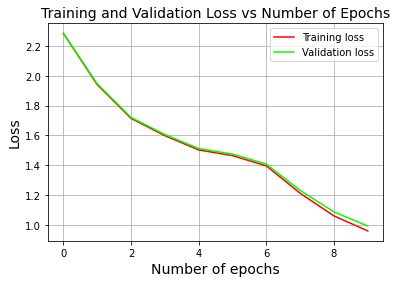

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: u3hdcigs with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: nestorov


lr_0.0001_ac_tanh_in_random_uniform_op_nestorov_bs_128_L2_0.0005_ep_40_nn_32_nh_3
Epoch number : 2
Training cost:  2.3026012492750407 	Validation cost: 2.302600144915441
Epoch number : 4
Training cost:  2.3026012492750407 	Validation cost: 2.302600144915441
Epoch number : 6
Training cost:  2.3026012492750407 	Validation cost: 2.302600144915441
Epoch number : 8
Training cost:  2.3026012492750407 	Validation cost: 2.302600144915441
Epoch number : 10
Training cost:  2.3026012492750407 	Validation cost: 2.302600144915441
Epoch number : 12
Training cost:  2.3026012492750407 	Validation cost: 2.302600144915441
Epoch number : 14
Training cost:  2.3026012492750407 	Validation cost: 2.302600144915441
Epoch number : 16
Training cost:  2.3026012492750407 	Validation cost: 2.302600144915441
Epoch number : 18
Training cost:  2.3026012492750407 	Validation cost: 2.302600144915441
Epoch number : 20
Training cost:  2.3026012492750407 	Validation cost: 2.302600144915441
Epoch number : 22
Training cost:

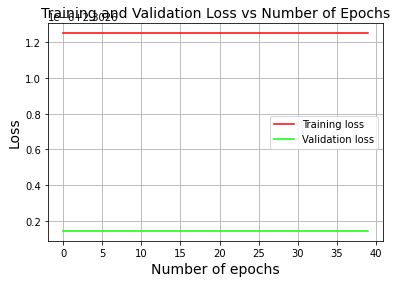

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 48g9px3o with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 512
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.0001_ac_sigmoid_in_random_normal_op_adam_bs_512_L2_0.0005_ep_10_nn_64_nh_3
Epoch number : 2
Training cost:  2.3025930387409965 	Validation cost: 2.3027741011189633
Epoch number : 4
Training cost:  2.3026091650772083 	Validation cost: 2.302614460912793
Epoch number : 6
Training cost:  2.302612472669997 	Validation cost: 2.302592953830541
Epoch number : 8
Training cost:  2.3026156702044953 	Validation cost: 2.302578733733207
Epoch number : 10
Training cost:  2.302618432000527 	Validation cost: 2.3025688199586023

Final training cost: 2.302619626987589


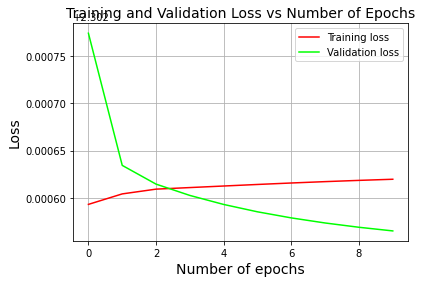

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 6lh16pqz with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum


lr_0.0001_ac_relu_in_xavier_op_momentum_bs_64_L2_0.5_ep_10_nn_32_nh_4
Epoch number : 2
Training cost:  2.316291043237528 	Validation cost: 2.320362310299161
Epoch number : 4
Training cost:  2.292052563748152 	Validation cost: 2.2962786177955254
Epoch number : 6
Training cost:  2.2743688587991797 	Validation cost: 2.2789282875195056
Epoch number : 8
Training cost:  2.25770153757054 	Validation cost: 2.26267196597468
Epoch number : 10
Training cost:  2.240785056829624 	Validation cost: 2.246094305076291

Final training cost: 2.2320277727482742


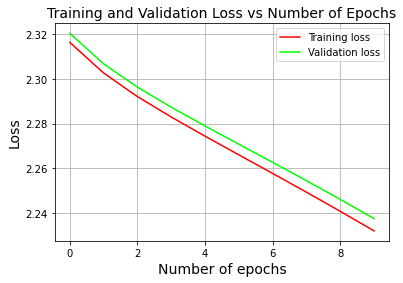

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: n7mrfz1b with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: RMSprop


lr_0.001_ac_sigmoid_in_random_normal_op_RMSprop_bs_32_L2_0.5_ep_40_nn_128_nh_5
Epoch number : 2
Training cost:  2.3093590328634894 	Validation cost: 2.3095728883781463
Epoch number : 4
Training cost:  2.3040238201573384 	Validation cost: 2.3034874147124182
Epoch number : 6
Training cost:  2.3030114481960893 	Validation cost: 2.302552484762183
Epoch number : 8
Training cost:  2.3027556648345673 	Validation cost: 2.302488775995951
Epoch number : 10
Training cost:  2.302670878456944 	Validation cost: 2.302524143529783
Epoch number : 12
Training cost:  2.3026379456146295 	Validation cost: 2.302561546736238
Epoch number : 14
Training cost:  2.3026223432046513 	Validation cost: 2.3025885134814574
Epoch number : 16
Training cost:  2.3026134411221264 	Validation cost: 2.302605719896085
Epoch number : 18
Training cost:  2.302607990006742 	Validation cost: 2.302615287318278
Epoch number : 20
Training cost:  2.3026044726802817 	Validation cost: 2.30262022107508
Epoch number : 22
Training cost:  2

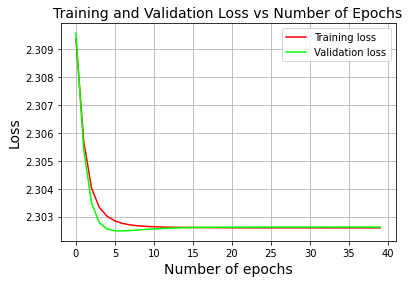

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 01532tcu with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum


lr_0.001_ac_relu_in_random_uniform_op_momentum_bs_64_L2_0_ep_40_nn_64_nh_5
Epoch number : 2
Training cost:  2.3025035683267556 	Validation cost: 2.302511189544943
Epoch number : 4
Training cost:  2.3023742164775913 	Validation cost: 2.3023970211567515
Epoch number : 6
Training cost:  2.30223822222943 	Validation cost: 2.302273042744691
Epoch number : 8
Training cost:  2.3020902509765864 	Validation cost: 2.302134080705597
Epoch number : 10
Training cost:  2.3019237722523487 	Validation cost: 2.3019736498453116
Epoch number : 12
Training cost:  2.301730224714895 	Validation cost: 2.3017830830683343
Epoch number : 14
Training cost:  2.30149772022638 	Validation cost: 2.3015501748495537
Epoch number : 16
Training cost:  2.3012088884189366 	Validation cost: 2.3012569180975895
Epoch number : 18
Training cost:  2.3008370721339566 	Validation cost: 2.3008755009239343
Epoch number : 20
Training cost:  2.3003392024911222 	Validation cost: 2.3003607974416864
Epoch number : 22
Training cost:  2.2

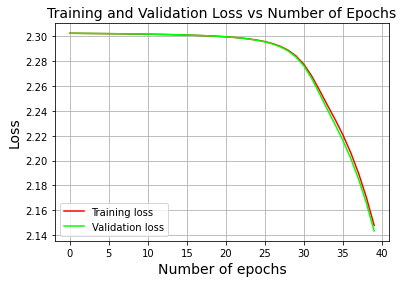

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 4goa1mav with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum


lr_0.001_ac_sigmoid_in_random_uniform_op_momentum_bs_128_L2_0.0005_ep_10_nn_64_nh_4
Epoch number : 2
Training cost:  2.3025921331333743 	Validation cost: 2.3026789074912366
Epoch number : 4
Training cost:  2.30257968429706 	Validation cost: 2.3027027939964806
Epoch number : 6
Training cost:  2.3025790232710754 	Validation cost: 2.3027085604992585
Epoch number : 8
Training cost:  2.302578955180581 	Validation cost: 2.30270962844756
Epoch number : 10
Training cost:  2.3025789442914504 	Validation cost: 2.3027098184283594

Final training cost: 2.302578942830664


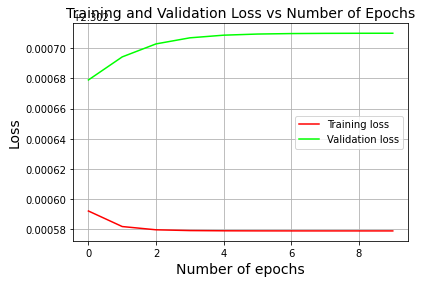

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 21hhjppl with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 512
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.0001_ac_relu_in_xavier_op_RMSprop_bs_512_L2_0_ep_20_nn_32_nh_3
Epoch number : 2
Training cost:  1.7225500128214308 	Validation cost: 1.7358699745132418
Epoch number : 4
Training cost:  0.9108468727580279 	Validation cost: 0.9254559926407782
Epoch number : 6
Training cost:  0.6861893124953115 	Validation cost: 0.7000989654787751
Epoch number : 8
Training cost:  0.5947706590611832 	Validation cost: 0.607283497143663
Epoch number : 10
Training cost:  0.5432575430994557 	Validation cost: 0.5554491441571432
Epoch number : 12
Training cost:  0.5095480096003985 	Validation cost: 0.5210654270486491
Epoch number : 14
Training cost:  0.48562827923425855 	Validation cost: 0.49675949876101266
Epoch number : 16
Training cost:  0.46773145037423813 	Validation cost: 0.47863339432162033
Epoch number : 18
Training cost:  0.45366958835447785 	Validation cost: 0.4646725035737236
Epoch number : 20
Training cost:  0.4421253377051869 	Validation cost: 0.45367367495085664

Final training cost: 0.4371975

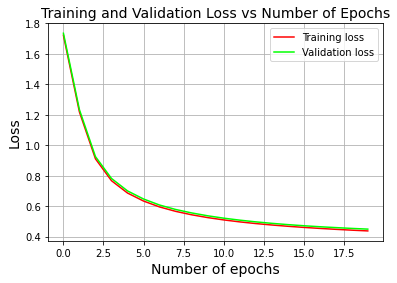

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 4b2xyv57 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: nestorov


lr_0.001_ac_relu_in_xavier_op_nestorov_bs_32_L2_0.5_ep_40_nn_128_nh_4
Epoch number : 2
Training cost:  2.314281821938446 	Validation cost: 2.3437380441679614
Epoch number : 4
Training cost:  2.314281821938446 	Validation cost: 2.3437380441679614
Epoch number : 6
Training cost:  2.314281821938446 	Validation cost: 2.3437380441679614
Epoch number : 8
Training cost:  2.314281821938446 	Validation cost: 2.3437380441679614
Epoch number : 10
Training cost:  2.314281821938446 	Validation cost: 2.3437380441679614
Epoch number : 12
Training cost:  2.314281821938446 	Validation cost: 2.3437380441679614
Epoch number : 14
Training cost:  2.314281821938446 	Validation cost: 2.3437380441679614
Epoch number : 16
Training cost:  2.314281821938446 	Validation cost: 2.3437380441679614
Epoch number : 18
Training cost:  2.314281821938446 	Validation cost: 2.3437380441679614
Epoch number : 20
Training cost:  2.314281821938446 	Validation cost: 2.3437380441679614
Epoch number : 22
Training cost:  2.31428182

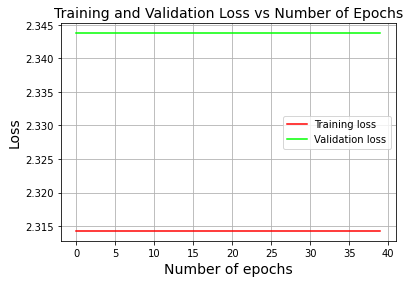

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 8a9y14ur with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.0001_ac_relu_in_random_normal_op_adam_bs_128_L2_0_ep_10_nn_64_nh_4
Epoch number : 2
Training cost:  2.3025866072648746 	Validation cost: 2.3025766380986044
Epoch number : 4
Training cost:  2.302594855698025 	Validation cost: 2.3025966457149076
Epoch number : 6
Training cost:  2.302601887508707 	Validation cost: 2.302617837031008
Epoch number : 8
Training cost:  2.3026051621358006 	Validation cost: 2.302630207412346
Epoch number : 10
Training cost:  2.3026062964612852 	Validation cost: 2.3026363305134727

Final training cost: 2.302606446787568


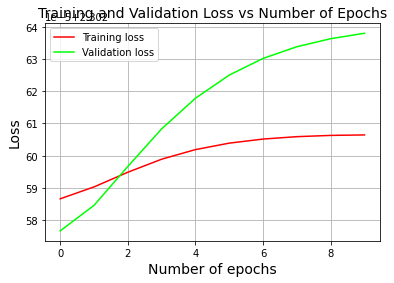

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 474dsi7e with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 512
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: adam


lr_0.001_ac_sigmoid_in_random_uniform_op_adam_bs_512_L2_0.5_ep_5_nn_128_nh_4
Epoch number : 2
Training cost:  2.3059555076224 	Validation cost: 2.304551492784017
Epoch number : 4
Training cost:  2.3076395791540025 	Validation cost: 2.3066582537569684
Epoch number : 6
Training cost:  2.307290981759318 	Validation cost: 2.3065510730652625

Final training cost: 2.307290981759318


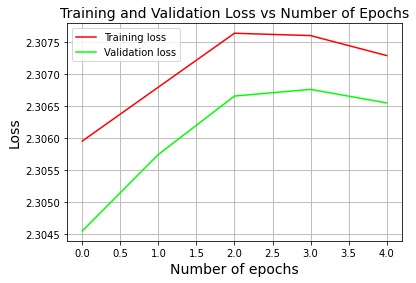

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: a5bo2ym8 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum


lr_0.001_ac_relu_in_random_uniform_op_momentum_bs_256_L2_0.5_ep_5_nn_128_nh_4
Epoch number : 2
Training cost:  2.2878682526474803 	Validation cost: 2.2869249973112584
Epoch number : 4
Training cost:  2.271993146964797 	Validation cost: 2.269609011048857
Epoch number : 6
Training cost:  2.264548528434729 	Validation cost: 2.261360450545587

Final training cost: 2.264548528434729


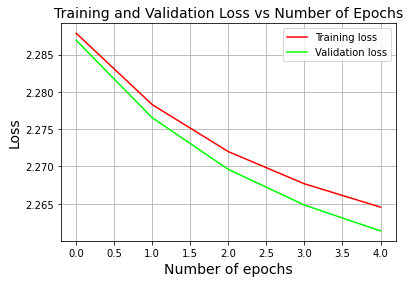

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: nupyhtv1 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: RMSprop


lr_0.001_ac_tanh_in_random_uniform_op_RMSprop_bs_64_L2_0.5_ep_10_nn_64_nh_5
Epoch number : 2
Training cost:  2.302585475934689 	Validation cost: 2.3026502807351887
Epoch number : 4
Training cost:  2.3025875246200873 	Validation cost: 2.3026578676323823
Epoch number : 6
Training cost:  2.3025872346198106 	Validation cost: 2.302656129522272
Epoch number : 8
Training cost:  2.3025873316110967 	Validation cost: 2.302652527204353
Epoch number : 10
Training cost:  2.3025873629431106 	Validation cost: 2.3026526168342296

Final training cost: 2.3025877019973726


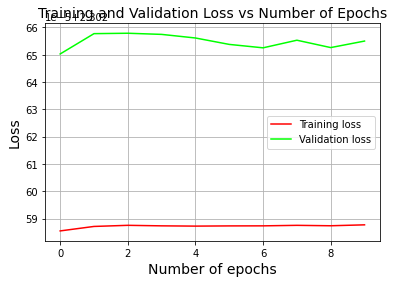

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: hpk7vsij with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: adam


lr_0.001_ac_tanh_in_random_uniform_op_adam_bs_256_L2_0.0005_ep_20_nn_32_nh_5
Epoch number : 2
Training cost:  2.302594881791091 	Validation cost: 2.302620648784201
Epoch number : 4
Training cost:  2.302575603732078 	Validation cost: 2.3026244620143217
Epoch number : 6
Training cost:  1.6713211686277247 	Validation cost: 1.6770993168375246
Epoch number : 8
Training cost:  1.3542497934098179 	Validation cost: 1.361353273462797
Epoch number : 10
Training cost:  1.154815389323565 	Validation cost: 1.1631007267167084
Epoch number : 12
Training cost:  1.0579467135341063 	Validation cost: 1.071945593530982
Epoch number : 14
Training cost:  1.0049815885097075 	Validation cost: 1.025799972148111
Epoch number : 16
Training cost:  1.0038133871469475 	Validation cost: 1.0281950860563018
Epoch number : 18
Training cost:  0.9752351885944787 	Validation cost: 0.9999456149999353
Epoch number : 20
Training cost:  0.9951189332500928 	Validation cost: 1.0167714432199848

Final training cost: 0.9047717462

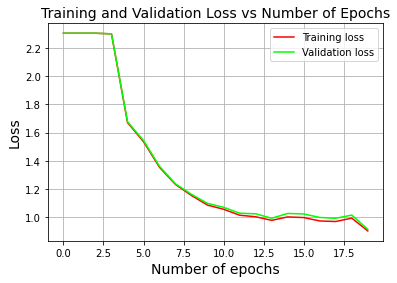

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: hthzxeuk with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd


lr_0.0001_ac_tanh_in_xavier_op_sgd_bs_32_L2_0_ep_20_nn_32_nh_3
Epoch number : 2
Training cost:  2.1594988354718216 	Validation cost: 2.1577346862756657
Epoch number : 4
Training cost:  1.8445428480202288 	Validation cost: 1.8470617061534695
Epoch number : 6
Training cost:  1.6473546051128185 	Validation cost: 1.6522701709605678
Epoch number : 8
Training cost:  1.51062563852385 	Validation cost: 1.5168496471676918
Epoch number : 10
Training cost:  1.4067838753018067 	Validation cost: 1.4140091606991478
Epoch number : 12
Training cost:  1.323642118497012 	Validation cost: 1.3317089443640515
Epoch number : 14
Training cost:  1.254365992225209 	Validation cost: 1.2631578808326358
Epoch number : 16
Training cost:  1.1948278812149 	Validation cost: 1.2042478728146937
Epoch number : 18
Training cost:  1.1425405097717436 	Validation cost: 1.1525006232763502
Epoch number : 20
Training cost:  1.0960027389543903 	Validation cost: 1.1064199278375102

Final training cost: 1.0745815233740648


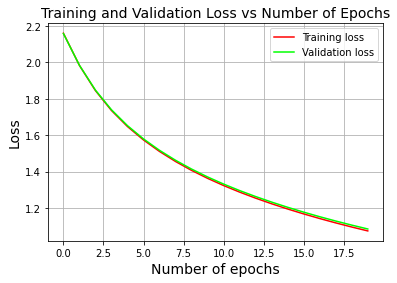

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wzold2o2 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 512
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd


lr_0.0001_ac_tanh_in_random_uniform_op_sgd_bs_512_L2_0_ep_20_nn_32_nh_5
Epoch number : 2
Training cost:  2.3025847589935267 	Validation cost: 2.3025848986678046
Epoch number : 4
Training cost:  2.3025847254590337 	Validation cost: 2.3025851970025064
Epoch number : 6
Training cost:  2.302584692066441 	Validation cost: 2.3025854947761495
Epoch number : 8
Training cost:  2.302584658815145 	Validation cost: 2.3025857919896153
Epoch number : 10
Training cost:  2.3025846257045446 	Validation cost: 2.3025860886437837
Epoch number : 12
Training cost:  2.3025845927340436 	Validation cost: 2.302586384739534
Epoch number : 14
Training cost:  2.302584559903044 	Validation cost: 2.3025866802777446
Epoch number : 16
Training cost:  2.3025845272109553 	Validation cost: 2.302586975259294
Epoch number : 18
Training cost:  2.3025844946571854 	Validation cost: 2.302587269685061
Epoch number : 20
Training cost:  2.3025844622411453 	Validation cost: 2.302587563555921

Final training cost: 2.302584446084590

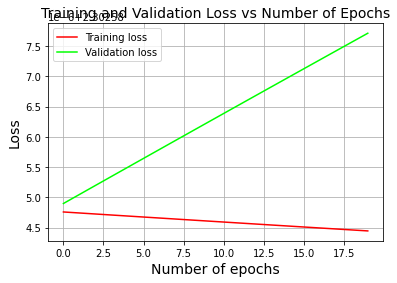

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: niw6xal6 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: RMSprop


lr_0.0001_ac_tanh_in_random_normal_op_RMSprop_bs_256_L2_0_ep_5_nn_128_nh_4
Epoch number : 2
Training cost:  1.680725392340939 	Validation cost: 1.6854248290209641
Epoch number : 4
Training cost:  1.3037452755457608 	Validation cost: 1.3082312488904835
Epoch number : 6
Training cost:  1.0091534377206213 	Validation cost: 1.0197353040434314

Final training cost: 1.0091534377206213


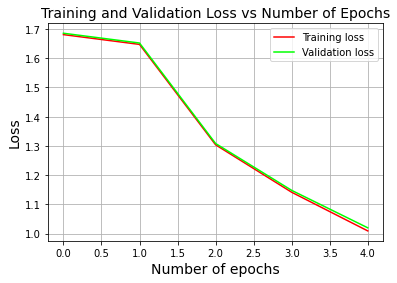

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 343dn2bb with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: adam


lr_0.0001_ac_tanh_in_xavier_op_adam_bs_64_L2_0.5_ep_5_nn_128_nh_4
Epoch number : 2
Training cost:  0.49171237743679924 	Validation cost: 0.5112074424909324
Epoch number : 4
Training cost:  0.4488078793259342 	Validation cost: 0.4614698938887723
Epoch number : 6
Training cost:  0.43678415446752045 	Validation cost: 0.44875392152337606

Final training cost: 0.43678415446752045


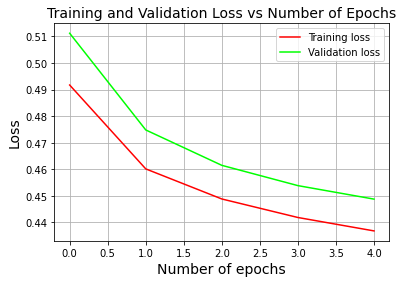

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: jmjjy8e3 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum


lr_0.0001_ac_relu_in_random_uniform_op_momentum_bs_64_L2_0_ep_20_nn_128_nh_4
Epoch number : 2
Training cost:  2.295570078549306 	Validation cost: 2.2950124254425406
Epoch number : 4
Training cost:  2.2852327098240806 	Validation cost: 2.2838949356015674
Epoch number : 6
Training cost:  2.2780061986578093 	Validation cost: 2.2760377002562735
Epoch number : 8
Training cost:  2.272808734204872 	Validation cost: 2.270329547034309
Epoch number : 10
Training cost:  2.268986058554691 	Validation cost: 2.2660993562752947
Epoch number : 12
Training cost:  2.2660879019359164 	Validation cost: 2.262882607682542
Epoch number : 14
Training cost:  2.263794223065663 	Validation cost: 2.2603448094481027
Epoch number : 16
Training cost:  2.2618826525447706 	Validation cost: 2.258249117567474
Epoch number : 18
Training cost:  2.26020472211801 	Validation cost: 2.25643357524835
Epoch number : 20
Training cost:  2.258664958040652 	Validation cost: 2.2547910346970634

Final training cost: 2.257927213869336

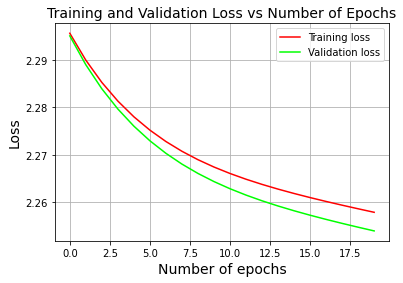

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: or0nqhag with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.0001_ac_relu_in_xavier_op_nadam_bs_256_L2_0.0005_ep_20_nn_128_nh_4
Epoch number : 2
Training cost:  0.7516009070105658 	Validation cost: 0.7642492823104138
Epoch number : 4
Training cost:  0.49947833541123837 	Validation cost: 0.5112328973637368
Epoch number : 6
Training cost:  0.45643264220296825 	Validation cost: 0.47062993613928067
Epoch number : 8
Training cost:  0.4318591545325276 	Validation cost: 0.4468514835760687
Epoch number : 10
Training cost:  0.4086884780623044 	Validation cost: 0.4268795631513209
Epoch number : 12
Training cost:  0.3898968545032811 	Validation cost: 0.41209381799651484
Epoch number : 14
Training cost:  0.37354635626936733 	Validation cost: 0.40124408806673384
Epoch number : 16
Training cost:  0.35882439755472373 	Validation cost: 0.39231149932500553
Epoch number : 18
Training cost:  0.34183178953582743 	Validation cost: 0.3823444082447694
Epoch number : 20
Training cost:  0.33007681357023505 	Validation cost: 0.37585474875405184

Final training cost:

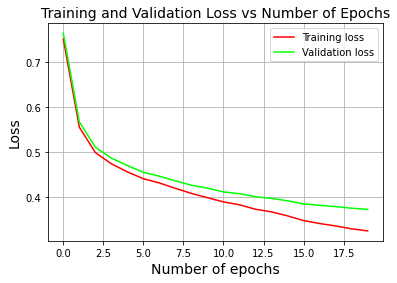

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 57zu4yyl with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.001_ac_tanh_in_random_uniform_op_RMSprop_bs_256_L2_0.0005_ep_40_nn_32_nh_5
Epoch number : 2
Training cost:  1.699794869238256 	Validation cost: 1.6979574176945806
Epoch number : 4
Training cost:  1.3140149974632844 	Validation cost: 1.316071424087553
Epoch number : 6
Training cost:  1.122769101812403 	Validation cost: 1.1300996631396298
Epoch number : 8
Training cost:  0.9733334446016602 	Validation cost: 0.994993784470509
Epoch number : 10
Training cost:  0.805691680099075 	Validation cost: 0.8384521320239049
Epoch number : 12
Training cost:  0.7105349149379934 	Validation cost: 0.752059530333155
Epoch number : 14
Training cost:  0.6677235168991538 	Validation cost: 0.7159165576740211
Epoch number : 16
Training cost:  0.6371485419753294 	Validation cost: 0.6923185227000097
Epoch number : 18
Training cost:  0.6018997076738465 	Validation cost: 0.6610623536419568
Epoch number : 20
Training cost:  0.5671323256396228 	Validation cost: 0.6307368332730013
Epoch number : 22
Training cos

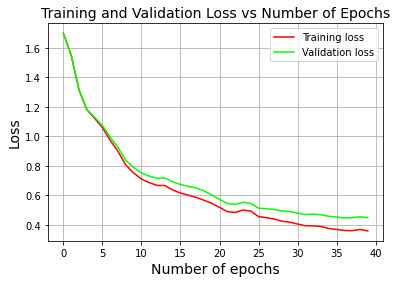

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 6xpdxfh2 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: adam


lr_0.0001_ac_sigmoid_in_random_uniform_op_adam_bs_32_L2_0.0005_ep_40_nn_128_nh_4
Epoch number : 2
Training cost:  2.304553883329385 	Validation cost: 2.3041299960774775
Epoch number : 4
Training cost:  2.3044437235336575 	Validation cost: 2.3039933232464747
Epoch number : 6
Training cost:  2.3040704142544466 	Validation cost: 2.303574792638483
Epoch number : 8
Training cost:  2.303705747098285 	Validation cost: 2.3031978836398426
Epoch number : 10
Training cost:  2.303361053031748 	Validation cost: 2.302892860151229
Epoch number : 12
Training cost:  2.303044436254197 	Validation cost: 2.302665026538041
Epoch number : 14
Training cost:  2.302733595265627 	Validation cost: 2.3024695288309327
Epoch number : 16
Training cost:  2.3023803669236123 	Validation cost: 2.302237344865978
Epoch number : 18
Training cost:  2.3019332648897355 	Validation cost: 2.3019122616760477
Epoch number : 20
Training cost:  2.3012775051988212 	Validation cost: 2.3013700996217112
Epoch number : 22
Training cost:

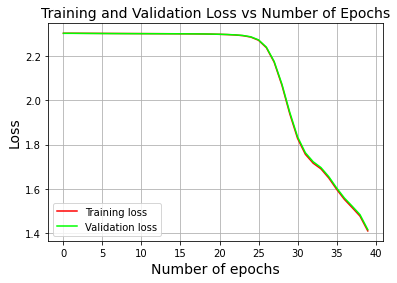

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: kzidstre with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 512
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: RMSprop


lr_0.001_ac_relu_in_random_uniform_op_RMSprop_bs_512_L2_0_ep_5_nn_64_nh_3
Epoch number : 2
Training cost:  1.9056853104576268 	Validation cost: 1.8959466499979298
Epoch number : 4
Training cost:  1.4167251202805642 	Validation cost: 1.4101084934455985
Epoch number : 6
Training cost:  1.0337095980729576 	Validation cost: 1.033059949798938

Final training cost: 1.0337095980729576


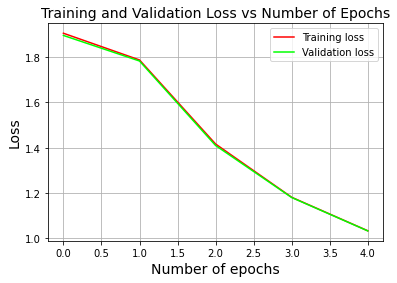

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 6exoxsoe with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum


lr_0.0001_ac_tanh_in_random_uniform_op_momentum_bs_16_L2_0.5_ep_20_nn_64_nh_5
Epoch number : 2
Training cost:  2.3025852083226632 	Validation cost: 2.302669873938574
Epoch number : 4
Training cost:  2.30257894358465 	Validation cost: 2.3026700067564922
Epoch number : 6
Training cost:  2.302574082261433 	Validation cost: 2.3026711182618245
Epoch number : 8
Training cost:  2.302570389155242 	Validation cost: 2.302672989584103
Epoch number : 10
Training cost:  2.3025676629700986 	Validation cost: 2.302675436925565
Epoch number : 12
Training cost:  2.3025657318154127 	Validation cost: 2.3026783066603476
Epoch number : 14
Training cost:  2.302564449313366 	Validation cost: 2.302681471105075
Epoch number : 16
Training cost:  2.3025636912128045 	Validation cost: 2.302684824854716
Epoch number : 18
Training cost:  2.302563352433592 	Validation cost: 2.3026882815997705
Epoch number : 20
Training cost:  2.3025633444808857 	Validation cost: 2.302691771357212

Final training cost: 2.30256344088158

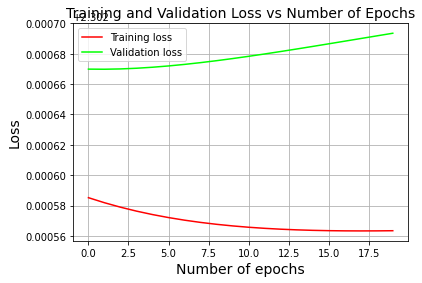

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: rjcp12nm with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 512
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum


lr_0.001_ac_relu_in_random_normal_op_momentum_bs_512_L2_0.5_ep_10_nn_64_nh_4
Epoch number : 2
Training cost:  2.3026135186459737 	Validation cost: 2.302850023060328
Epoch number : 4
Training cost:  2.3026130905510285 	Validation cost: 2.3028527421533425
Epoch number : 6
Training cost:  2.302612705059034 	Validation cost: 2.302855442169561
Epoch number : 8
Training cost:  2.302612373771608 	Validation cost: 2.3028581350546595
Epoch number : 10
Training cost:  2.3026120693539647 	Validation cost: 2.302860787683832

Final training cost: 2.3026119217564283


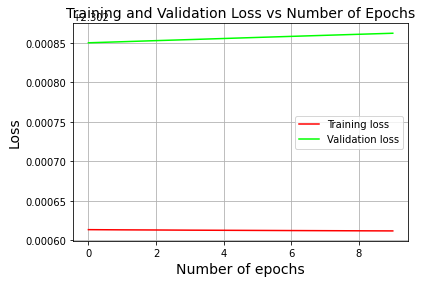

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 1frgqegh with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: adam


lr_0.0001_ac_relu_in_xavier_op_adam_bs_256_L2_0.5_ep_10_nn_128_nh_5
Epoch number : 2
Training cost:  0.7827715274993378 	Validation cost: 0.8222722809156779
Epoch number : 4
Training cost:  0.5230342248648516 	Validation cost: 0.5600069815356357
Epoch number : 6
Training cost:  0.47476311092758955 	Validation cost: 0.5108692437150565
Epoch number : 8
Training cost:  0.44546175488408774 	Validation cost: 0.48205005328075834
Epoch number : 10
Training cost:  0.425576619001867 	Validation cost: 0.46347774523732754

Final training cost: 0.4160877710168686


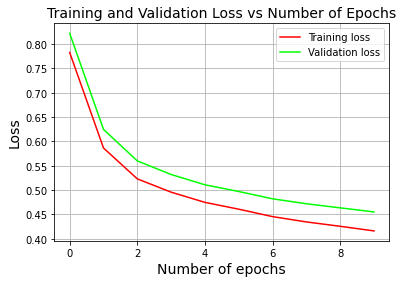

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: bnal63t8 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: nestorov


lr_0.0001_ac_tanh_in_random_uniform_op_nestorov_bs_32_L2_0.0005_ep_20_nn_128_nh_4
Epoch number : 2
Training cost:  2.3025507950932846 	Validation cost: 2.302512050981632
Epoch number : 4
Training cost:  2.3025507950932846 	Validation cost: 2.302512050981632
Epoch number : 6
Training cost:  2.3025507950932846 	Validation cost: 2.302512050981632
Epoch number : 8
Training cost:  2.3025507950932846 	Validation cost: 2.302512050981632
Epoch number : 10
Training cost:  2.3025507950932846 	Validation cost: 2.302512050981632
Epoch number : 12
Training cost:  2.3025507950932846 	Validation cost: 2.302512050981632
Epoch number : 14
Training cost:  2.3025507950932846 	Validation cost: 2.302512050981632
Epoch number : 16
Training cost:  2.3025507950932846 	Validation cost: 2.302512050981632
Epoch number : 18
Training cost:  2.3025507950932846 	Validation cost: 2.302512050981632
Epoch number : 20
Training cost:  2.3025507950932846 	Validation cost: 2.302512050981632

Final training cost: 2.30255079

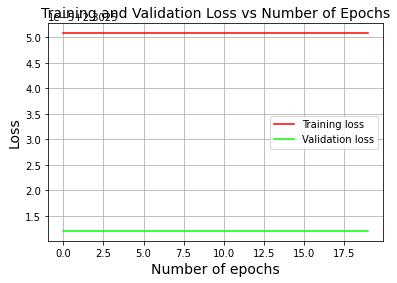

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: k23jw0dv with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: momentum


lr_0.001_ac_relu_in_random_normal_op_momentum_bs_16_L2_0.0005_ep_40_nn_32_nh_4
Epoch number : 2
Training cost:  2.302581546236839 	Validation cost: 2.3026212414337697
Epoch number : 4
Training cost:  2.302578675761377 	Validation cost: 2.3026682864790953
Epoch number : 6
Training cost:  2.302577845139669 	Validation cost: 2.302692790320988
Epoch number : 8
Training cost:  2.302577585935339 	Validation cost: 2.3027053929284014
Epoch number : 10
Training cost:  2.3025774952083053 	Validation cost: 2.302711831133053
Epoch number : 12
Training cost:  2.3025774595552226 	Validation cost: 2.3027151067496825
Epoch number : 14
Training cost:  2.3025774438089157 	Validation cost: 2.302716771565852
Epoch number : 16
Training cost:  2.302577436022781 	Validation cost: 2.3027176157176927
Epoch number : 18
Training cost:  2.3025774316575265 	Validation cost: 2.302718044427428
Epoch number : 20
Training cost:  2.3025774287268703 	Validation cost: 2.302718259219799
Epoch number : 22
Training cost:  2

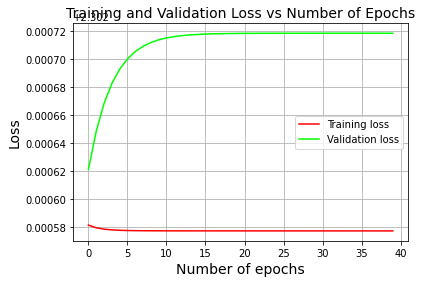

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: khpsmzk8 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.001_ac_sigmoid_in_random_uniform_op_RMSprop_bs_128_L2_0_ep_40_nn_32_nh_5
Epoch number : 2
Training cost:  2.3018570371177307 	Validation cost: 2.3020509225145926
Epoch number : 4
Training cost:  2.158257516873993 	Validation cost: 2.162027310830285
Epoch number : 6
Training cost:  1.7446909741472567 	Validation cost: 1.750590616772141
Epoch number : 8
Training cost:  1.6189476513460317 	Validation cost: 1.6260631274855308
Epoch number : 10
Training cost:  1.5068104586119337 	Validation cost: 1.5161847089140268
Epoch number : 12
Training cost:  1.4564914886679863 	Validation cost: 1.4660674450606708
Epoch number : 14
Training cost:  1.331958597052958 	Validation cost: 1.3426769833652294
Epoch number : 16
Training cost:  1.150659593167929 	Validation cost: 1.1675278321384743
Epoch number : 18
Training cost:  1.0469444129843655 	Validation cost: 1.069488688009314
Epoch number : 20
Training cost:  0.9627072263683766 	Validation cost: 0.9931948990846697
Epoch number : 22
Training cost:

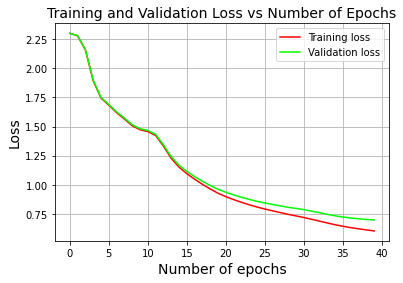

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: c1rbxfrq with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: RMSprop


lr_0.001_ac_sigmoid_in_xavier_op_RMSprop_bs_64_L2_0.5_ep_20_nn_128_nh_5
Epoch number : 2
Training cost:  2.312453881096667 	Validation cost: 2.313593743089927
Epoch number : 4
Training cost:  2.3085995903262875 	Validation cost: 2.3089749563609763
Epoch number : 6
Training cost:  2.3073366467130176 	Validation cost: 2.3074831052630196
Epoch number : 8
Training cost:  2.3064228032975502 	Validation cost: 2.306417456828078
Epoch number : 10
Training cost:  2.3051102682281597 	Validation cost: 2.3048680336861107
Epoch number : 12
Training cost:  2.303798610990862 	Validation cost: 2.303321414139495
Epoch number : 14
Training cost:  2.3031166022989606 	Validation cost: 2.302637339045997
Epoch number : 16
Training cost:  2.3028424494515214 	Validation cost: 2.3024815659299787
Epoch number : 18
Training cost:  2.302722110978824 	Validation cost: 2.3024752662416854
Epoch number : 20
Training cost:  2.302660304863731 	Validation cost: 2.302504222704026

Final training cost: 2.3026416965775196


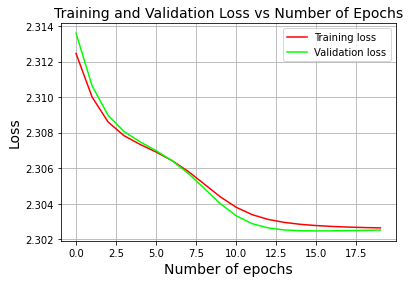

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: eutpz6jy with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: adam


lr_0.0001_ac_sigmoid_in_random_uniform_op_adam_bs_64_L2_0.0005_ep_5_nn_128_nh_5
Epoch number : 2
Training cost:  2.304084836597137 	Validation cost: 2.3034503517411697
Epoch number : 4
Training cost:  2.3042813359945042 	Validation cost: 2.3035764904897453
Epoch number : 6
Training cost:  2.3042066696080954 	Validation cost: 2.303514995785855

Final training cost: 2.3042066696080954


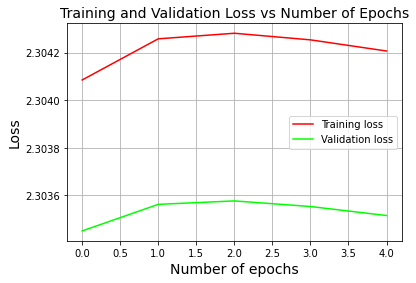

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 1lq95xic with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 512
wandb: 	epochs: 20
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum


lr_0.0001_ac_relu_in_random_normal_op_momentum_bs_512_L2_0.5_ep_20_nn_128_nh_5
Epoch number : 2
Training cost:  2.3026623217312303 	Validation cost: 2.3032812021138334
Epoch number : 4
Training cost:  2.3026622532620324 	Validation cost: 2.30328144176026
Epoch number : 6
Training cost:  2.3026622043052605 	Validation cost: 2.3032816986768037
Epoch number : 8
Training cost:  2.3026621580247877 	Validation cost: 2.303281957546962
Epoch number : 10
Training cost:  2.3026621181232745 	Validation cost: 2.3032822223719833
Epoch number : 12
Training cost:  2.302662078914898 	Validation cost: 2.303282487461655
Epoch number : 14
Training cost:  2.3026620396220467 	Validation cost: 2.3032827519316363
Epoch number : 16
Training cost:  2.302661999972826 	Validation cost: 2.303283014935926
Epoch number : 18
Training cost:  2.3026619613802572 	Validation cost: 2.3032832782742223
Epoch number : 20
Training cost:  2.302661920156642 	Validation cost: 2.3032835382168932

Final training cost: 2.302661901

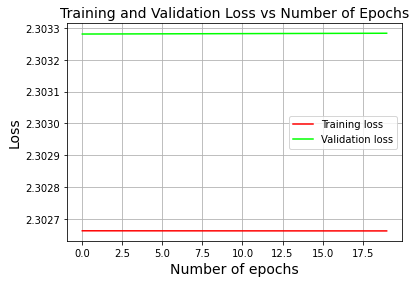

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: l9zxuk8y with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam


lr_0.0001_ac_relu_in_random_normal_op_nadam_bs_128_L2_0.0005_ep_10_nn_64_nh_3
Epoch number : 2
Training cost:  2.3025472796428894 	Validation cost: 2.302536586249487
Epoch number : 4
Training cost:  2.2145509498045297 	Validation cost: 2.212279474876645
Epoch number : 6
Training cost:  1.007214605169746 	Validation cost: 1.0115255561689795
Epoch number : 8
Training cost:  0.9342101266513054 	Validation cost: 0.941601855330906
Epoch number : 10
Training cost:  0.8674853309448763 	Validation cost: 0.8770802595687865

Final training cost: 0.8243885635867328


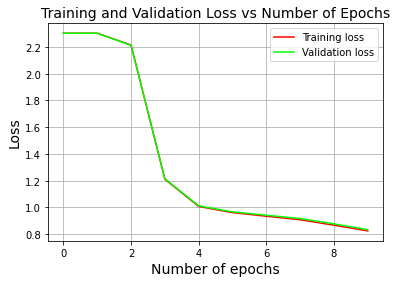

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: yy3o3pym with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 512
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: RMSprop


lr_0.001_ac_relu_in_xavier_op_RMSprop_bs_512_L2_0.0005_ep_40_nn_128_nh_3
Epoch number : 2
Training cost:  0.49833622829097934 	Validation cost: 0.5130264784108384
Epoch number : 4
Training cost:  0.393782858395985 	Validation cost: 0.4138335580114575
Epoch number : 6
Training cost:  0.33908558494967794 	Validation cost: 0.37275444892441406
Epoch number : 8
Training cost:  0.3032252429260016 	Validation cost: 0.3506378828190652
Epoch number : 10
Training cost:  0.27267108213812324 	Validation cost: 0.3330632326318547
Epoch number : 12
Training cost:  0.2784329636418413 	Validation cost: 0.35347588245694966
Epoch number : 14
Training cost:  0.2722073417334747 	Validation cost: 0.354624137112093
Epoch number : 16
Training cost:  0.31105010435822805 	Validation cost: 0.41269930211311845
Epoch number : 18
Training cost:  0.26352467599968327 	Validation cost: 0.37102410331673197
Epoch number : 20
Training cost:  0.24215604252199718 	Validation cost: 0.3723205200573152
Epoch number : 22
Train

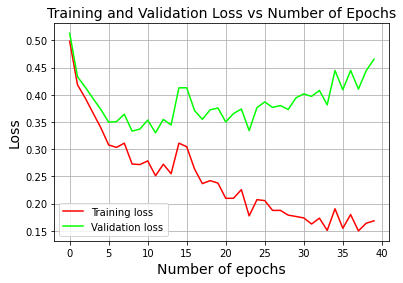

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: s42ymbj5 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.0001_ac_relu_in_random_normal_op_sgd_bs_256_L2_0.5_ep_10_nn_128_nh_4
Epoch number : 2
Training cost:  2.3026542292444736 	Validation cost: 2.303213537559804
Epoch number : 4
Training cost:  2.302653783854925 	Validation cost: 2.303213675800775
Epoch number : 6
Training cost:  2.3026535045771452 	Validation cost: 2.3032139697159595
Epoch number : 8
Training cost:  2.3026532583331663 	Validation cost: 2.3032142815872017
Epoch number : 10
Training cost:  2.302653010158988 	Validation cost: 2.303214586437453

Final training cost: 2.302652911803845


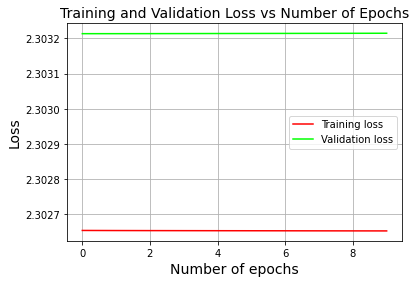

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: fax0gge1 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: adam


lr_0.001_ac_sigmoid_in_xavier_op_adam_bs_256_L2_0.5_ep_5_nn_32_nh_5
Epoch number : 2
Training cost:  2.303651053898612 	Validation cost: 2.307248011612077
Epoch number : 4
Training cost:  2.3038297511819836 	Validation cost: 2.304534546552261
Epoch number : 6
Training cost:  2.3038792602611022 	Validation cost: 2.3038311501606583

Final training cost: 2.3038792602611022


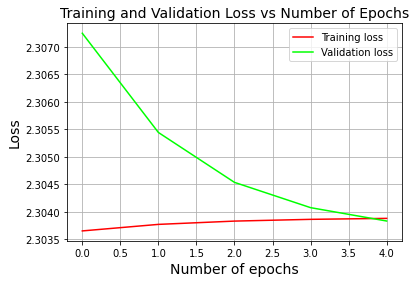

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: ytw394mi with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam


lr_0.0001_ac_sigmoid_in_random_normal_op_nadam_bs_16_L2_0.5_ep_40_nn_32_nh_5
Epoch number : 2
Training cost:  2.3069716815976067 	Validation cost: 2.307762125354914
Epoch number : 4
Training cost:  2.3081446416431923 	Validation cost: 2.3091123325871825
Epoch number : 6
Training cost:  2.3075468591829322 	Validation cost: 2.308592518753069
Epoch number : 8
Training cost:  2.3067689547927226 	Validation cost: 2.307753766403532
Epoch number : 10
Training cost:  2.306109925909576 	Validation cost: 2.306994043133729
Epoch number : 12
Training cost:  2.3056773703611064 	Validation cost: 2.306502287488264
Epoch number : 14
Training cost:  2.3054335800123615 	Validation cost: 2.306236669741971
Epoch number : 16
Training cost:  2.305318136913152 	Validation cost: 2.3061182394410378
Epoch number : 18
Training cost:  2.3052847025794714 	Validation cost: 2.3060918189096262
Epoch number : 20
Training cost:  2.30530359175928 	Validation cost: 2.306124314917895
Epoch number : 22
Training cost:  2.30

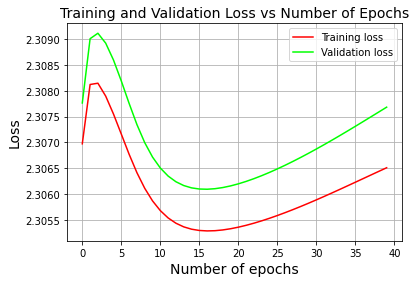

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: mfyxrj85 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 20
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd


lr_0.001_ac_sigmoid_in_random_normal_op_sgd_bs_128_L2_0.5_ep_20_nn_64_nh_4
Epoch number : 2
Training cost:  2.3026922999604156 	Validation cost: 2.3030163865661133
Epoch number : 4
Training cost:  2.3026113695718524 	Validation cost: 2.3029613198896155
Epoch number : 6
Training cost:  2.3026074106047902 	Validation cost: 2.302961768010872
Epoch number : 8
Training cost:  2.302607156222636 	Validation cost: 2.3029613537564995
Epoch number : 10
Training cost:  2.3026069975434864 	Validation cost: 2.302960003319558
Epoch number : 12
Training cost:  2.3026068197859453 	Validation cost: 2.3029584026040175
Epoch number : 14
Training cost:  2.30260663615393 	Validation cost: 2.3029567498287924
Epoch number : 16
Training cost:  2.3026064519482263 	Validation cost: 2.3029550932221077
Epoch number : 18
Training cost:  2.302606268527831 	Validation cost: 2.3029534440782595
Epoch number : 20
Training cost:  2.3026060862121445 	Validation cost: 2.3029518049795668

Final training cost: 2.30260599549

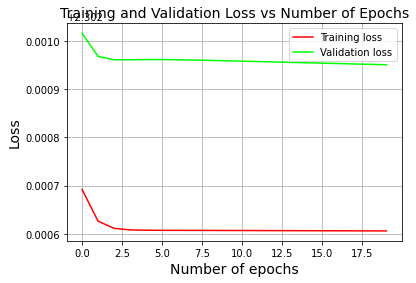

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 822v1c3q with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd


lr_0.001_ac_sigmoid_in_random_uniform_op_sgd_bs_128_L2_0.5_ep_40_nn_64_nh_5
Epoch number : 2
Training cost:  2.3026049588631405 	Validation cost: 2.302691675641564
Epoch number : 4
Training cost:  2.3025904733916502 	Validation cost: 2.302771009552609
Epoch number : 6
Training cost:  2.302589340437947 	Validation cost: 2.302786763903054
Epoch number : 8
Training cost:  2.302589129594298 	Validation cost: 2.3027892477022944
Epoch number : 10
Training cost:  2.302589036707702 	Validation cost: 2.302789236516576
Epoch number : 12
Training cost:  2.302588964223398 	Validation cost: 2.302788766647311
Epoch number : 14
Training cost:  2.302588895822172 	Validation cost: 2.3027882151836305
Epoch number : 16
Training cost:  2.3025888285354092 	Validation cost: 2.3027876517383685
Epoch number : 18
Training cost:  2.302588761811745 	Validation cost: 2.302787089149259
Epoch number : 20
Training cost:  2.30258869554646 	Validation cost: 2.3027865297692753
Epoch number : 22
Training cost:  2.302588

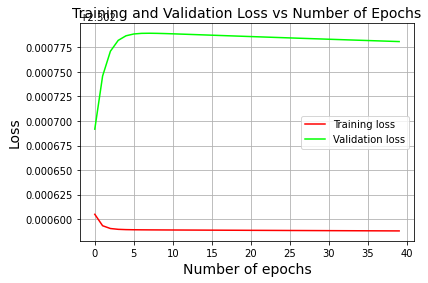

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: lwdh92ix with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 512
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.001_ac_sigmoid_in_random_normal_op_RMSprop_bs_512_L2_0.0005_ep_40_nn_32_nh_5
Epoch number : 2
Training cost:  2.3027749505899044 	Validation cost: 2.3024855166079985
Epoch number : 4
Training cost:  2.3026486083788873 	Validation cost: 2.3025269281239025
Epoch number : 6
Training cost:  2.3025318552197582 	Validation cost: 2.3026122704578524
Epoch number : 8
Training cost:  2.296837448167965 	Validation cost: 2.2975700050909365
Epoch number : 10
Training cost:  2.2695709916214137 	Validation cost: 2.270758444721188
Epoch number : 12
Training cost:  2.19931960846181 	Validation cost: 2.201620442459915
Epoch number : 14
Training cost:  2.063607291080099 	Validation cost: 2.067521058269815
Epoch number : 16
Training cost:  1.8894180212121432 	Validation cost: 1.8947477552404413
Epoch number : 18
Training cost:  1.7555818029585821 	Validation cost: 1.761575466846592
Epoch number : 20
Training cost:  1.6919374914187966 	Validation cost: 1.6976240362836994
Epoch number : 22
Training cos

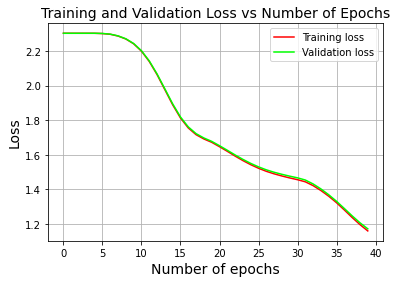

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: fcxm3ccr with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: nestorov


lr_0.001_ac_tanh_in_xavier_op_nestorov_bs_32_L2_0.5_ep_10_nn_32_nh_5
Epoch number : 2
Training cost:  2.3325680205112294 	Validation cost: 2.3391209878709986
Epoch number : 4
Training cost:  2.3325680205112294 	Validation cost: 2.3391209878709986
Epoch number : 6
Training cost:  2.3325680205112294 	Validation cost: 2.3391209878709986
Epoch number : 8
Training cost:  2.3325680205112294 	Validation cost: 2.3391209878709986
Epoch number : 10
Training cost:  2.3325680205112294 	Validation cost: 2.3391209878709986

Final training cost: 2.3325680205112294


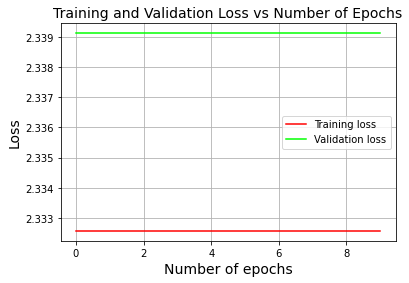

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 8satzr7f with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam


lr_0.001_ac_sigmoid_in_random_normal_op_nadam_bs_16_L2_0.5_ep_5_nn_32_nh_5
Epoch number : 2
Training cost:  2.3087616558185835 	Validation cost: 2.309216304525627
Epoch number : 4
Training cost:  2.3075396045144965 	Validation cost: 2.308574204069493
Epoch number : 6
Training cost:  2.3085606345590475 	Validation cost: 2.309577426712096

Final training cost: 2.3085606345590475


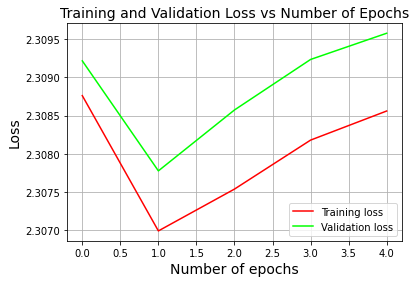

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: gl5eusda with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.001_ac_sigmoid_in_xavier_op_adam_bs_64_L2_0_ep_40_nn_64_nh_4
Epoch number : 2
Training cost:  0.9820778463447708 	Validation cost: 0.9802581685045755
Epoch number : 4
Training cost:  0.5502616576335634 	Validation cost: 0.5586310987127721
Epoch number : 6
Training cost:  0.4637439699975102 	Validation cost: 0.4778457990974302
Epoch number : 8
Training cost:  0.424090385926464 	Validation cost: 0.44530160754100917
Epoch number : 10
Training cost:  0.4269758194693432 	Validation cost: 0.45737342545582366
Epoch number : 12
Training cost:  0.40122939141039976 	Validation cost: 0.435050297211446
Epoch number : 14
Training cost:  0.3801136424825077 	Validation cost: 0.4231953473830311
Epoch number : 16
Training cost:  0.3561918764594323 	Validation cost: 0.41326193154833896
Epoch number : 18
Training cost:  0.3566931908450299 	Validation cost: 0.42656068417843335
Epoch number : 20
Training cost:  0.35766091481513224 	Validation cost: 0.44515454312592284
Epoch number : 22
Training cost: 

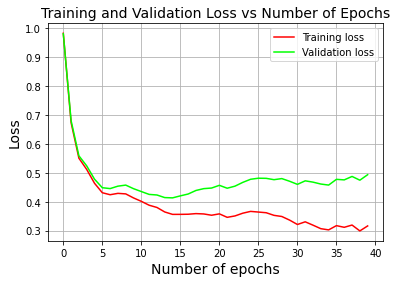

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 3ywwdqok with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: RMSprop


lr_0.0001_ac_sigmoid_in_xavier_op_RMSprop_bs_128_L2_0.0005_ep_40_nn_64_nh_5
Epoch number : 2
Training cost:  2.283472278185413 	Validation cost: 2.283527826769805
Epoch number : 4
Training cost:  1.745705658630463 	Validation cost: 1.7475025342988488
Epoch number : 6
Training cost:  1.3867192807266373 	Validation cost: 1.3914858668304986
Epoch number : 8
Training cost:  1.2292237971493445 	Validation cost: 1.2361014900759926
Epoch number : 10
Training cost:  1.135387612587418 	Validation cost: 1.142988247604176
Epoch number : 12
Training cost:  1.0728150797766636 	Validation cost: 1.0803311178467538
Epoch number : 14
Training cost:  1.028918928047792 	Validation cost: 1.035014533617097
Epoch number : 16
Training cost:  0.9805216147197708 	Validation cost: 0.9857505683146219
Epoch number : 18
Training cost:  0.9136247292173645 	Validation cost: 0.9202176462193219
Epoch number : 20
Training cost:  0.8524417321722089 	Validation cost: 0.8617525926655802
Epoch number : 22
Training cost:  0

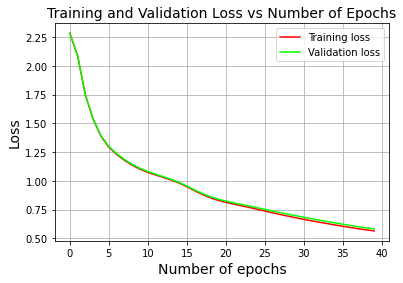

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 2frg114q with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.0001_ac_relu_in_xavier_op_adam_bs_32_L2_0_ep_5_nn_64_nh_4
Epoch number : 2
Training cost:  0.5030030903719204 	Validation cost: 0.5145793596277239
Epoch number : 4
Training cost:  0.40389658692634467 	Validation cost: 0.4248874943706446
Epoch number : 6
Training cost:  0.39945259735656413 	Validation cost: 0.42743517755867544

Final training cost: 0.39945259735656413


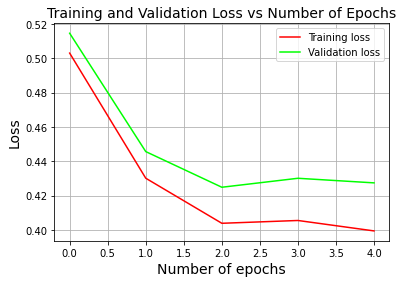

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: cr3k56yk with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: nestorov


lr_0.001_ac_sigmoid_in_random_uniform_op_nestorov_bs_32_L2_0_ep_10_nn_32_nh_4
Epoch number : 2
Training cost:  2.302626191432733 	Validation cost: 2.3025071983284833
Epoch number : 4
Training cost:  2.302626191432733 	Validation cost: 2.3025071983284833
Epoch number : 6
Training cost:  2.302626191432733 	Validation cost: 2.3025071983284833
Epoch number : 8
Training cost:  2.302626191432733 	Validation cost: 2.3025071983284833
Epoch number : 10
Training cost:  2.302626191432733 	Validation cost: 2.3025071983284833

Final training cost: 2.302626191432733


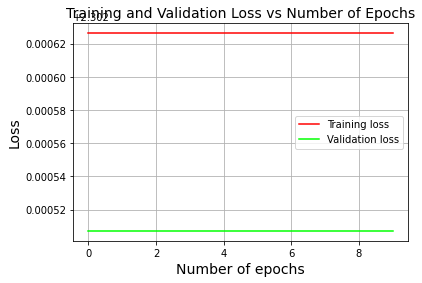

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: a8928wrh with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.001_ac_tanh_in_random_normal_op_RMSprop_bs_64_L2_0.0005_ep_10_nn_32_nh_5
Epoch number : 2
Training cost:  1.1996455695958337 	Validation cost: 1.2068044588496887
Epoch number : 4
Training cost:  0.8020849348373488 	Validation cost: 0.8116716684103342
Epoch number : 6
Training cost:  0.560185078102741 	Validation cost: 0.5924066621107662
Epoch number : 8
Training cost:  0.49070662162854395 	Validation cost: 0.5347309722457831
Epoch number : 10
Training cost:  0.3995184255451998 	Validation cost: 0.4478807519436045

Final training cost: 0.36897980155142446


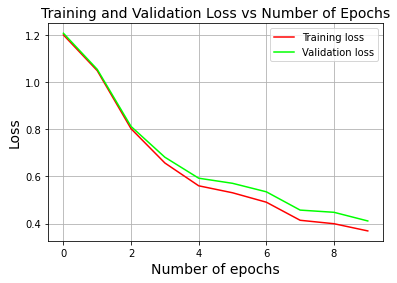

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: xm3w9mv1 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 512
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.0001_ac_tanh_in_random_uniform_op_adam_bs_512_L2_0.0005_ep_40_nn_64_nh_4
Epoch number : 2
Training cost:  2.3017803961300305 	Validation cost: 2.301723282588843
Epoch number : 4
Training cost:  2.2932865074381237 	Validation cost: 2.2926357775707236
Epoch number : 6
Training cost:  1.868448344622383 	Validation cost: 1.8742712567872482
Epoch number : 8
Training cost:  1.695543570370682 	Validation cost: 1.6998871155132314
Epoch number : 10
Training cost:  1.656740901171966 	Validation cost: 1.661306272488704
Epoch number : 12
Training cost:  1.640337376204306 	Validation cost: 1.6452878372024584
Epoch number : 14
Training cost:  1.6164096387653581 	Validation cost: 1.6218106979575568
Epoch number : 16
Training cost:  1.5619255923187112 	Validation cost: 1.5688805346984946
Epoch number : 18
Training cost:  1.4821497487756332 	Validation cost: 1.4903573131347414
Epoch number : 20
Training cost:  1.3846818634288787 	Validation cost: 1.3924630921868852
Epoch number : 22
Training cost:

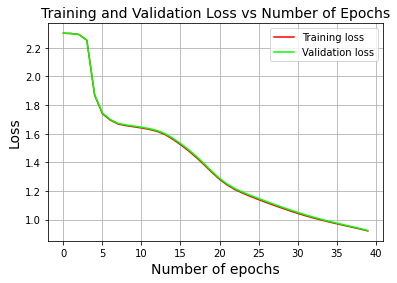

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: z006qxkk with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.0001_ac_tanh_in_random_normal_op_nadam_bs_16_L2_0.5_ep_10_nn_128_nh_5
Epoch number : 2
Training cost:  2.302609088577013 	Validation cost: 2.302738459851923
Epoch number : 4
Training cost:  2.302921689638649 	Validation cost: 2.303374905128368
Epoch number : 6
Training cost:  2.303545063370611 	Validation cost: 2.3042973394574955
Epoch number : 8
Training cost:  2.303324012167292 	Validation cost: 2.3037813306139836
Epoch number : 10
Training cost:  2.303441974091667 	Validation cost: 2.303670899386157

Final training cost: 2.3035791533170724


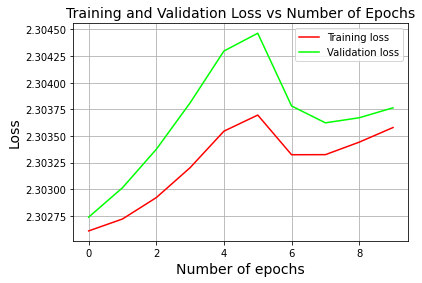

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 6570jdnz with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.0001_ac_relu_in_random_normal_op_sgd_bs_32_L2_0.5_ep_5_nn_128_nh_3
Epoch number : 2
Training cost:  2.3026323851765698 	Validation cost: 2.303131427298205
Epoch number : 4
Training cost:  2.3026246765999074 	Validation cost: 2.303123484541144
Epoch number : 6
Training cost:  2.302619827670126 	Validation cost: 2.3031183611796715

Final training cost: 2.302619827670126


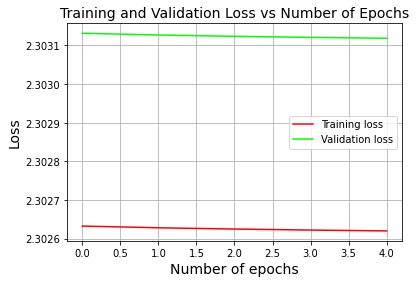

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: j85f4ci1 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: nestorov


lr_0.0001_ac_relu_in_xavier_op_nestorov_bs_16_L2_0.5_ep_5_nn_32_nh_5
Epoch number : 2
Training cost:  2.309012690438164 	Validation cost: 2.3156427382477727
Epoch number : 4
Training cost:  2.309012690438164 	Validation cost: 2.3156427382477727
Epoch number : 6
Training cost:  2.309012690438164 	Validation cost: 2.3156427382477727

Final training cost: 2.309012690438164


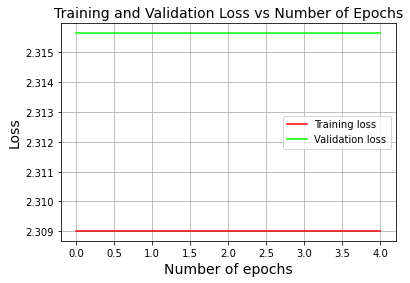

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 8fzewmlk with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: RMSprop


lr_0.001_ac_relu_in_random_uniform_op_RMSprop_bs_128_L2_0_ep_5_nn_128_nh_5
Epoch number : 2
Training cost:  1.7557009400357384 	Validation cost: 1.7487390254650248
Epoch number : 4
Training cost:  0.9746779514876301 	Validation cost: 0.9832391790674835
Epoch number : 6
Training cost:  0.709578775885951 	Validation cost: 0.7239739206365328

Final training cost: 0.709578775885951


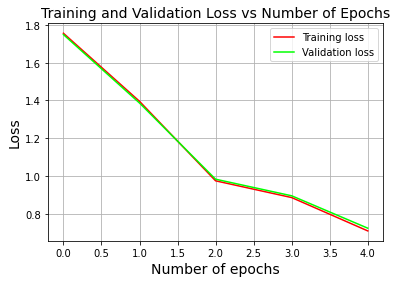

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: yqdvtq6c with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 512
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.001_ac_relu_in_random_uniform_op_adam_bs_512_L2_0.5_ep_40_nn_64_nh_4
Epoch number : 2
Training cost:  1.9753226752464073 	Validation cost: 1.9654072239512743
Epoch number : 4
Training cost:  1.793113322776541 	Validation cost: 1.7844331980411556
Epoch number : 6
Training cost:  1.6981677246503941 	Validation cost: 1.6970084869138926
Epoch number : 8
Training cost:  1.602633245895106 	Validation cost: 1.6038256151183927
Epoch number : 10
Training cost:  1.5513472138211768 	Validation cost: 1.5532144515072672
Epoch number : 12
Training cost:  1.516476959813952 	Validation cost: 1.519469452409605
Epoch number : 14
Training cost:  1.5037040137697844 	Validation cost: 1.507459052536545
Epoch number : 16
Training cost:  1.4820592527933425 	Validation cost: 1.4866811272794729
Epoch number : 18
Training cost:  1.4479922126087195 	Validation cost: 1.452639351706441
Epoch number : 20
Training cost:  1.1312991334692801 	Validation cost: 1.1361953830700382
Epoch number : 22
Training cost:  0.

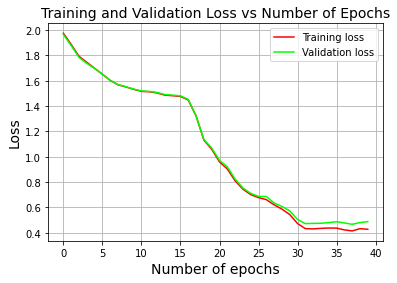

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: t2lbyoqa with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd


lr_0.0001_ac_relu_in_random_uniform_op_sgd_bs_64_L2_0_ep_5_nn_32_nh_4
Epoch number : 2
Training cost:  2.3025780256218042 	Validation cost: 2.3025785906887006
Epoch number : 4
Training cost:  2.3025768779444302 	Validation cost: 2.3025800381396873
Epoch number : 6
Training cost:  2.3025757382037955 	Validation cost: 2.302581449746277

Final training cost: 2.3025757382037955


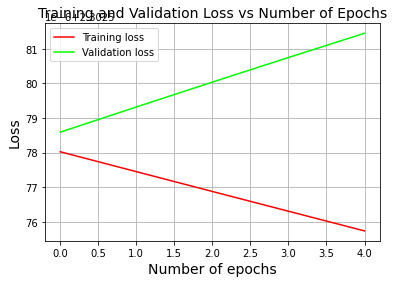

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: a4wy4367 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: nestorov


lr_0.0001_ac_tanh_in_xavier_op_nestorov_bs_64_L2_0_ep_10_nn_32_nh_4
Epoch number : 2
Training cost:  2.4362502785824236 	Validation cost: 2.4312255985593256
Epoch number : 4
Training cost:  2.4362502785824236 	Validation cost: 2.4312255985593256
Epoch number : 6
Training cost:  2.4362502785824236 	Validation cost: 2.4312255985593256
Epoch number : 8
Training cost:  2.4362502785824236 	Validation cost: 2.4312255985593256
Epoch number : 10
Training cost:  2.4362502785824236 	Validation cost: 2.4312255985593256

Final training cost: 2.4362502785824236


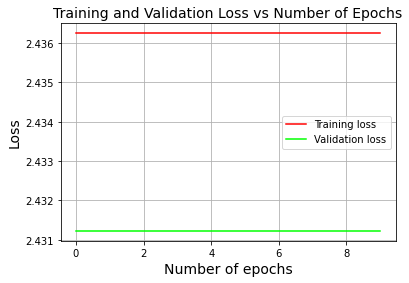

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: slhmw5bb with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam


lr_0.001_ac_tanh_in_random_uniform_op_nadam_bs_256_L2_0.0005_ep_40_nn_64_nh_5
Epoch number : 2
Training cost:  1.7123889771981047 	Validation cost: 1.7174187618517665
Epoch number : 4
Training cost:  1.3764632927311038 	Validation cost: 1.3760640457441602
Epoch number : 6
Training cost:  1.178648856319541 	Validation cost: 1.185668094832909
Epoch number : 8
Training cost:  1.1050434241562743 	Validation cost: 1.11876633492503
Epoch number : 10
Training cost:  1.0816554072110012 	Validation cost: 1.0980474101413034
Epoch number : 12
Training cost:  1.0483128327159568 	Validation cost: 1.0620163407662377
Epoch number : 14
Training cost:  1.0302309885573606 	Validation cost: 1.0514719022619097
Epoch number : 16
Training cost:  0.9306002806198527 	Validation cost: 0.9623430074160922
Epoch number : 18
Training cost:  0.6035534439891891 	Validation cost: 0.6372796308397916
Epoch number : 20
Training cost:  0.500075060967906 	Validation cost: 0.5380277301332665
Epoch number : 22
Training cost

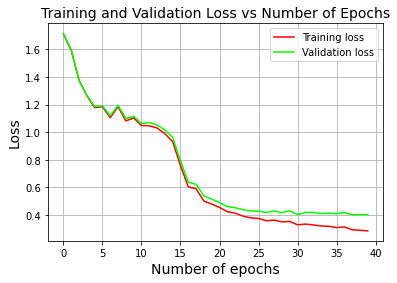

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: eidbiwb5 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 512
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nestorov


lr_0.0001_ac_tanh_in_random_uniform_op_nestorov_bs_512_L2_0.5_ep_40_nn_64_nh_3
Epoch number : 2
Training cost:  2.3026904871024327 	Validation cost: 2.302779397336782
Epoch number : 4
Training cost:  2.3026904871024327 	Validation cost: 2.302779397336782
Epoch number : 6
Training cost:  2.3026904871024327 	Validation cost: 2.302779397336782
Epoch number : 8
Training cost:  2.3026904871024327 	Validation cost: 2.302779397336782
Epoch number : 10
Training cost:  2.3026904871024327 	Validation cost: 2.302779397336782
Epoch number : 12
Training cost:  2.3026904871024327 	Validation cost: 2.302779397336782
Epoch number : 14
Training cost:  2.3026904871024327 	Validation cost: 2.302779397336782
Epoch number : 16
Training cost:  2.3026904871024327 	Validation cost: 2.302779397336782
Epoch number : 18
Training cost:  2.3026904871024327 	Validation cost: 2.302779397336782
Epoch number : 20
Training cost:  2.3026904871024327 	Validation cost: 2.302779397336782
Epoch number : 22
Training cost:  2

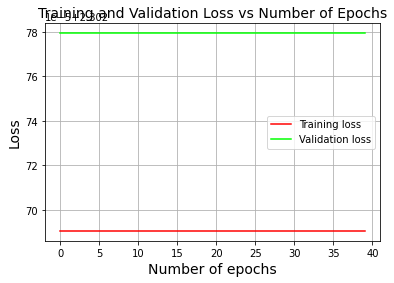

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 58tpvjf5 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.0001_ac_tanh_in_xavier_op_nadam_bs_64_L2_0_ep_40_nn_128_nh_5
Epoch number : 2
Training cost:  0.4570051219229537 	Validation cost: 0.46224856782970397
Epoch number : 4
Training cost:  0.37877687812220207 	Validation cost: 0.39204985885096394
Epoch number : 6
Training cost:  0.3436324692836008 	Validation cost: 0.36476766147315187
Epoch number : 8
Training cost:  0.31947461099435065 	Validation cost: 0.35076562131806943
Epoch number : 10
Training cost:  0.2999965709706959 	Validation cost: 0.3412135166880973
Epoch number : 12
Training cost:  0.2831910144085586 	Validation cost: 0.33298145817569247
Epoch number : 14
Training cost:  0.2689030227759025 	Validation cost: 0.3267190621966507
Epoch number : 16
Training cost:  0.2570477940275041 	Validation cost: 0.3225794243894751
Epoch number : 18
Training cost:  0.2470473092571482 	Validation cost: 0.3201427968516572
Epoch number : 20
Training cost:  0.23591892830511302 	Validation cost: 0.31752185475106537
Epoch number : 22
Training co

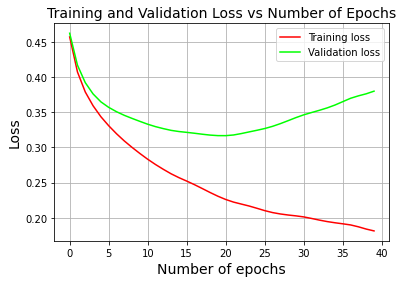

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 6hddh5q9 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd


lr_0.001_ac_relu_in_random_normal_op_sgd_bs_32_L2_0_ep_10_nn_64_nh_5
Epoch number : 2
Training cost:  2.3025829099383843 	Validation cost: 2.302606279052803
Epoch number : 4
Training cost:  2.3025802348113005 	Validation cost: 2.302640036511926
Epoch number : 6
Training cost:  2.302578847513575 	Validation cost: 2.3026646206338888
Epoch number : 8
Training cost:  2.3025781220383386 	Validation cost: 2.302682409453375
Epoch number : 10
Training cost:  2.3025777394759777 	Validation cost: 2.3026952210260663

Final training cost: 2.302577621549668


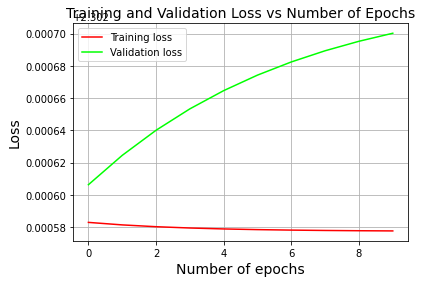

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 025tacmy with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.0001_ac_relu_in_random_normal_op_nadam_bs_16_L2_0.0005_ep_40_nn_128_nh_4
Epoch number : 2
Training cost:  2.3026046237279343 	Validation cost: 2.3027376473651064
Epoch number : 4
Training cost:  1.0929252020300027 	Validation cost: 1.0939596855491804
Epoch number : 6
Training cost:  0.8488741831745417 	Validation cost: 0.8595308373637718
Epoch number : 8
Training cost:  0.45841440909452197 	Validation cost: 0.47478576999417504
Epoch number : 10
Training cost:  0.4654198525665596 	Validation cost: 0.49597113003373555
Epoch number : 12
Training cost:  nan 	Validation cost: nan
Epoch number : 14
Training cost:  nan 	Validation cost: nan
Epoch number : 16
Training cost:  nan 	Validation cost: nan
Epoch number : 18
Training cost:  nan 	Validation cost: nan
Epoch number : 20
Training cost:  nan 	Validation cost: nan
Epoch number : 22
Training cost:  nan 	Validation cost: nan
Epoch number : 24
Training cost:  nan 	Validation cost: nan
Epoch number : 26
Training cost:  nan 	Validation cos

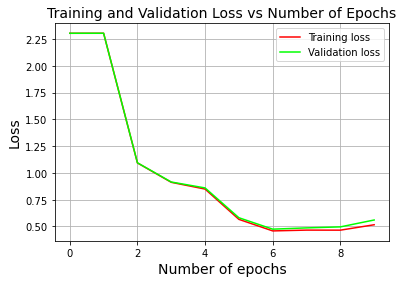

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: om1vzke4 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: adam


lr_0.0001_ac_sigmoid_in_xavier_op_adam_bs_256_L2_0.5_ep_20_nn_32_nh_5
Epoch number : 2
Training cost:  2.3062576595093165 	Validation cost: 2.313469129530759
Epoch number : 4
Training cost:  2.3032850929594413 	Validation cost: 2.3094224987385155
Epoch number : 6
Training cost:  2.3031900944357364 	Validation cost: 2.308487494875661
Epoch number : 8
Training cost:  2.3031193346405487 	Validation cost: 2.307691624302087
Epoch number : 10
Training cost:  2.3030641279743866 	Validation cost: 2.307012340727899
Epoch number : 12
Training cost:  2.3030184710576456 	Validation cost: 2.306430254732688
Epoch number : 14
Training cost:  2.3029789557358065 	Validation cost: 2.305929957855303
Epoch number : 16
Training cost:  2.3029437966559 	Validation cost: 2.3054991173610353
Epoch number : 18
Training cost:  2.3029121182597607 	Validation cost: 2.3051276809373813
Epoch number : 20
Training cost:  2.3028835007158914 	Validation cost: 2.304807290649081

Final training cost: 2.3028702661729334


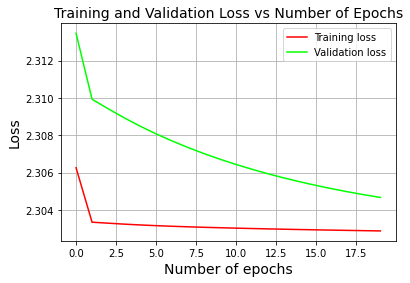

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: btw4i47n with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum


lr_0.0001_ac_sigmoid_in_random_normal_op_momentum_bs_16_L2_0.5_ep_40_nn_64_nh_3
Epoch number : 2
Training cost:  2.3028093059921955 	Validation cost: 2.303452655265766
Epoch number : 4
Training cost:  2.302622244962628 	Validation cost: 2.303048218345943
Epoch number : 6
Training cost:  2.3026041082879147 	Validation cost: 2.302956669391144
Epoch number : 8
Training cost:  2.302601752006005 	Validation cost: 2.3029259722033375
Epoch number : 10
Training cost:  2.302600751569299 	Validation cost: 2.3029108781772574
Epoch number : 12
Training cost:  2.30259985102367 	Validation cost: 2.302900532194359
Epoch number : 14
Training cost:  2.302598973230461 	Validation cost: 2.3028918632883935
Epoch number : 16
Training cost:  2.302598123831277 	Validation cost: 2.3028839377158303
Epoch number : 18
Training cost:  2.3025973065870056 	Validation cost: 2.3028764589255766
Epoch number : 20
Training cost:  2.3025965220038698 	Validation cost: 2.302869326121538
Epoch number : 22
Training cost:  2.

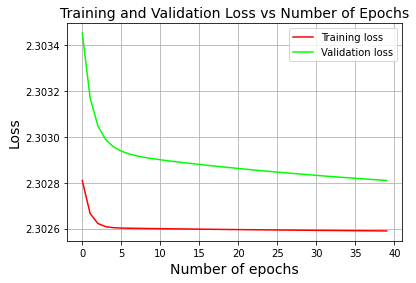

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: ftqu1saq with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 512
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: nestorov


lr_0.0001_ac_tanh_in_xavier_op_nestorov_bs_512_L2_0.0005_ep_5_nn_32_nh_4
Epoch number : 2
Training cost:  2.4362510769043433 	Validation cost: 2.4312327834566014
Epoch number : 4
Training cost:  2.4362510769043433 	Validation cost: 2.4312327834566014
Epoch number : 6
Training cost:  2.4362510769043433 	Validation cost: 2.4312327834566014

Final training cost: 2.4362510769043433


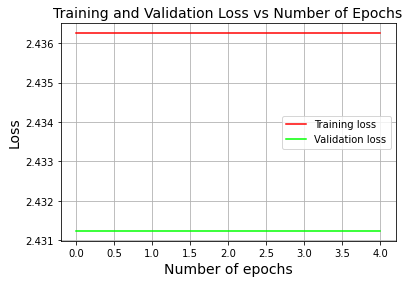

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: gtx3v4ao with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: nestorov


lr_0.001_ac_tanh_in_xavier_op_nestorov_bs_128_L2_0.5_ep_10_nn_32_nh_3
Epoch number : 2
Training cost:  2.417054656963586 	Validation cost: 2.417067833616741
Epoch number : 4
Training cost:  2.417054656963586 	Validation cost: 2.417067833616741
Epoch number : 6
Training cost:  2.417054656963586 	Validation cost: 2.417067833616741
Epoch number : 8
Training cost:  2.417054656963586 	Validation cost: 2.417067833616741
Epoch number : 10
Training cost:  2.417054656963586 	Validation cost: 2.417067833616741

Final training cost: 2.417054656963586


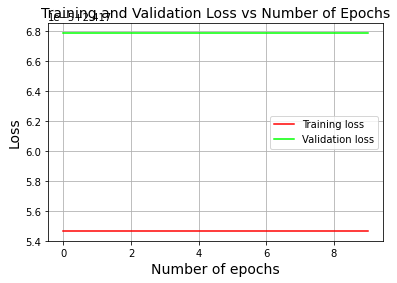

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: ug8cjjy4 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd


lr_0.001_ac_relu_in_random_uniform_op_sgd_bs_128_L2_0.5_ep_5_nn_32_nh_5
Epoch number : 2
Training cost:  2.302588146882643 	Validation cost: 2.3026308030540172
Epoch number : 4
Training cost:  2.3025869082379935 	Validation cost: 2.30264150091412
Epoch number : 6
Training cost:  2.3025858486453457 	Validation cost: 2.3026513935617343

Final training cost: 2.3025858486453457


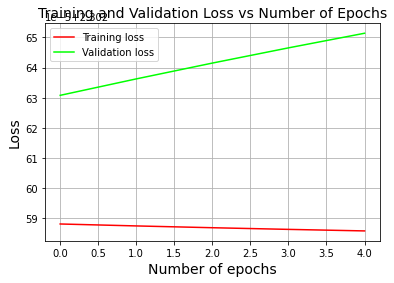

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: g4pefn6o with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.001_ac_tanh_in_random_normal_op_adam_bs_256_L2_0.0005_ep_40_nn_64_nh_4
Epoch number : 2
Training cost:  2.302591162430095 	Validation cost: 2.3026172295098952
Epoch number : 4
Training cost:  1.673620691838828 	Validation cost: 1.6792564750054262
Epoch number : 6
Training cost:  0.9485457851945146 	Validation cost: 0.9532910905091838
Epoch number : 8
Training cost:  0.5385252314545713 	Validation cost: 0.5419522579459142
Epoch number : 10
Training cost:  0.47031049809162645 	Validation cost: 0.47425845757380286
Epoch number : 12
Training cost:  0.4451239724668094 	Validation cost: 0.4656878774884436
Epoch number : 14
Training cost:  0.4235770707232483 	Validation cost: 0.4512791952728551
Epoch number : 16
Training cost:  0.382349617238489 	Validation cost: 0.4117626736895419
Epoch number : 18
Training cost:  0.3838181927270065 	Validation cost: 0.42156566377232474
Epoch number : 20
Training cost:  0.37184332664733255 	Validation cost: 0.4153712330374
Epoch number : 22
Training cos

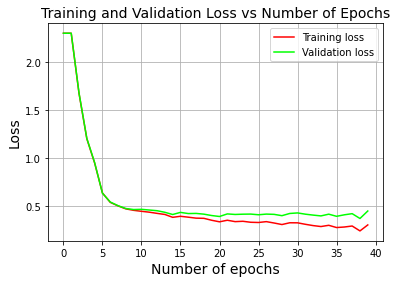

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: r5bwnm91 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam


lr_0.0001_ac_tanh_in_xavier_op_nadam_bs_256_L2_0.5_ep_20_nn_64_nh_4
Epoch number : 2
Training cost:  0.8277705987181274 	Validation cost: 0.8486119217224598
Epoch number : 4
Training cost:  0.49390765566375694 	Validation cost: 0.5095310306934814
Epoch number : 6
Training cost:  0.4306435780330518 	Validation cost: 0.446280404033986
Epoch number : 8
Training cost:  0.4025274065188327 	Validation cost: 0.420354154210916
Epoch number : 10
Training cost:  0.38643880895110533 	Validation cost: 0.4062659312634248
Epoch number : 12
Training cost:  0.3754653398989913 	Validation cost: 0.3970205303552102
Epoch number : 14
Training cost:  0.36699612659740094 	Validation cost: 0.39014910136844966
Epoch number : 16
Training cost:  0.3598909533226683 	Validation cost: 0.38464509746353426
Epoch number : 18
Training cost:  0.35380150271321453 	Validation cost: 0.3801669205626087
Epoch number : 20
Training cost:  0.34839177388431003 	Validation cost: 0.3763781572144753

Final training cost: 0.3458753

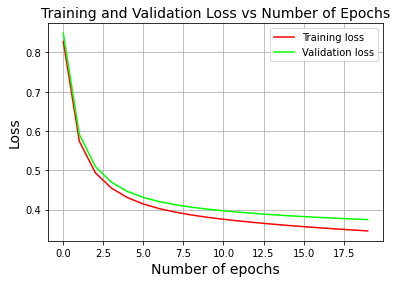

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: yzc1xuh8 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.001_ac_sigmoid_in_xavier_op_RMSprop_bs_16_L2_0_ep_40_nn_32_nh_5
Epoch number : 2
Training cost:  0.9217126049832192 	Validation cost: 0.9278947212512095
Epoch number : 4
Training cost:  0.6639062284235699 	Validation cost: 0.6884973921134101
Epoch number : 6
Training cost:  0.5961605648869546 	Validation cost: 0.6280745932541266
Epoch number : 8
Training cost:  0.558033045592345 	Validation cost: 0.6006250489741101
Epoch number : 10
Training cost:  0.5377171798903481 	Validation cost: 0.588856089063956
Epoch number : 12
Training cost:  0.5125962331169609 	Validation cost: 0.5680077493018147
Epoch number : 14
Training cost:  0.49866344525236883 	Validation cost: 0.5634942607734665
Epoch number : 16
Training cost:  0.4867519660646882 	Validation cost: 0.5565522740206822
Epoch number : 18
Training cost:  0.48129796401972735 	Validation cost: 0.5556535681092334
Epoch number : 20
Training cost:  0.47915220532039415 	Validation cost: 0.56003573915557
Epoch number : 22
Training cost:  0.

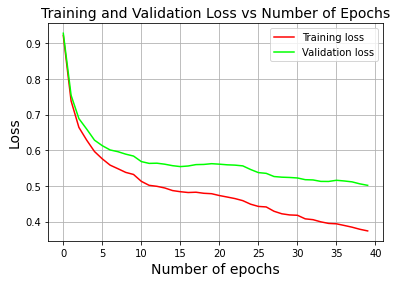

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 0ins0rpt with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: adam


lr_0.0001_ac_tanh_in_random_normal_op_adam_bs_64_L2_0.5_ep_40_nn_32_nh_3
Epoch number : 2
Training cost:  2.302588843391346 	Validation cost: 2.3026130651498815
Epoch number : 4
Training cost:  2.302621115580258 	Validation cost: 2.3026573546896087
Epoch number : 6
Training cost:  2.302675494899283 	Validation cost: 2.302736740805724
Epoch number : 8
Training cost:  2.3027212047630763 	Validation cost: 2.3027967329413697
Epoch number : 10
Training cost:  2.302752179478853 	Validation cost: 2.3028342385335026
Epoch number : 12
Training cost:  2.3027694388291753 	Validation cost: 2.3028538684746525
Epoch number : 14
Training cost:  2.302772138090933 	Validation cost: 2.302856850472945
Epoch number : 16
Training cost:  2.3027555985752866 	Validation cost: 2.3028389661051576
Epoch number : 18
Training cost:  2.3027206064851007 	Validation cost: 2.3027998866410493
Epoch number : 20
Training cost:  2.302683620662556 	Validation cost: 2.3027549393407183
Epoch number : 22
Training cost:  2.302

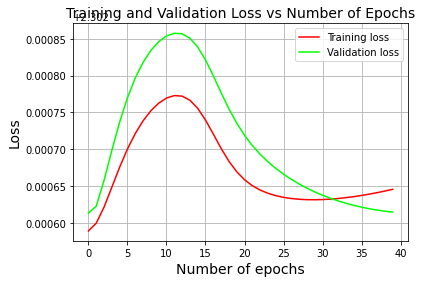

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: qtad2lwo with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.0001_ac_sigmoid_in_xavier_op_sgd_bs_16_L2_0_ep_10_nn_128_nh_3
Epoch number : 2
Training cost:  2.3218645658826875 	Validation cost: 2.322843055061044
Epoch number : 4
Training cost:  2.3018384050585876 	Validation cost: 2.302035379340993
Epoch number : 6
Training cost:  2.3007558578572236 	Validation cost: 2.300885313231182
Epoch number : 8
Training cost:  2.2998152746708604 	Validation cost: 2.2999482101603625
Epoch number : 10
Training cost:  2.29886986550823 	Validation cost: 2.2990120645779384

Final training cost: 2.298394351899938


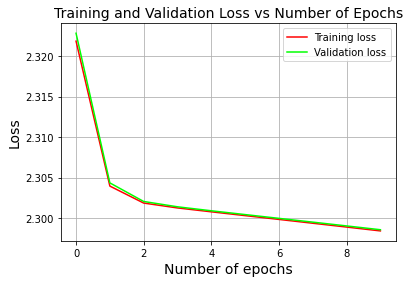

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: wohinduf with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 512
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: adam


lr_0.0001_ac_sigmoid_in_xavier_op_adam_bs_512_L2_0_ep_10_nn_128_nh_5
Epoch number : 2
Training cost:  2.305881392528964 	Validation cost: 2.305402045962909
Epoch number : 4
Training cost:  2.302645695172627 	Validation cost: 2.30236727913035
Epoch number : 6
Training cost:  2.302573536677073 	Validation cost: 2.302250716171607
Epoch number : 8
Training cost:  2.3024858384557465 	Validation cost: 2.30213639536752
Epoch number : 10
Training cost:  2.3023863651508525 	Validation cost: 2.3020194325818117

Final training cost: 2.3023323460008736


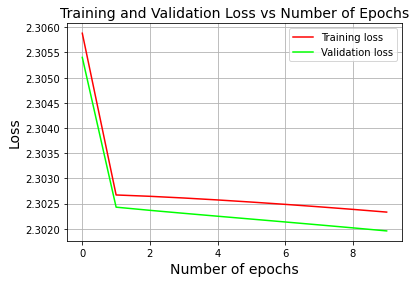

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: w5lacht0 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd


lr_0.001_ac_tanh_in_random_uniform_op_sgd_bs_256_L2_0.0005_ep_5_nn_64_nh_4
Epoch number : 2
Training cost:  2.3025913137514245 	Validation cost: 2.302595304403031
Epoch number : 4
Training cost:  2.302547921717186 	Validation cost: 2.302555154824651
Epoch number : 6
Training cost:  2.3025046024127516 	Validation cost: 2.302514904347836

Final training cost: 2.3025046024127516


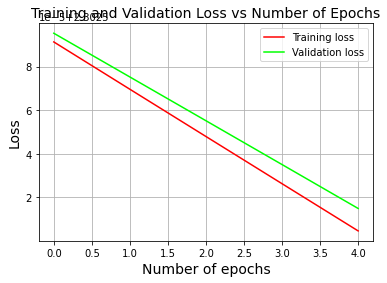

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: tzjruzow with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam


lr_0.0001_ac_tanh_in_random_normal_op_nadam_bs_64_L2_0.5_ep_40_nn_32_nh_4
Epoch number : 2
Training cost:  2.302590862358455 	Validation cost: 2.302616055295655
Epoch number : 4
Training cost:  2.3026211858053127 	Validation cost: 2.3026573788000984
Epoch number : 6
Training cost:  2.302675552974144 	Validation cost: 2.302736789771886
Epoch number : 8
Training cost:  2.302721371841774 	Validation cost: 2.3027969181793693
Epoch number : 10
Training cost:  2.3027527079736965 	Validation cost: 2.3028347923093504
Epoch number : 12
Training cost:  2.302771062411697 	Validation cost: 2.3028555384380263
Epoch number : 14
Training cost:  2.302776559109892 	Validation cost: 2.302861442398192
Epoch number : 16
Training cost:  2.3027645049055128 	Validation cost: 2.3028485325759034
Epoch number : 18
Training cost:  2.302731416830652 	Validation cost: 2.302812337845735
Epoch number : 20
Training cost:  2.3026911056380035 	Validation cost: 2.3027648536205376
Epoch number : 22
Training cost:  2.3026

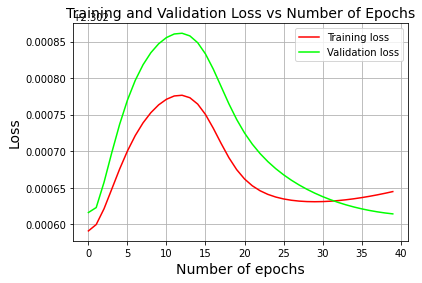

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: jkqjp7jb with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.001_ac_relu_in_xavier_op_sgd_bs_32_L2_0.5_ep_40_nn_128_nh_3
Epoch number : 2
Training cost:  1.2111485803292943 	Validation cost: 1.2403542914506813
Epoch number : 4
Training cost:  0.7513025408413402 	Validation cost: 0.7800535756574783
Epoch number : 6
Training cost:  0.652541155088339 	Validation cost: 0.6800007915602275
Epoch number : 8
Training cost:  0.6028237362914298 	Validation cost: 0.6288367388872579
Epoch number : 10
Training cost:  0.5736478949378688 	Validation cost: 0.598106410438603
Epoch number : 12
Training cost:  0.5548713958780692 	Validation cost: 0.5778633336496759
Epoch number : 14
Training cost:  0.5417526248555165 	Validation cost: 0.5633796026597873
Epoch number : 16
Training cost:  0.5321221972895592 	Validation cost: 0.5524302900439364
Epoch number : 18
Training cost:  0.5247870037937734 	Validation cost: 0.5439490401021231
Epoch number : 20
Training cost:  0.5189836080542549 	Validation cost: 0.5370923724929324
Epoch number : 22
Training cost:  0.51427

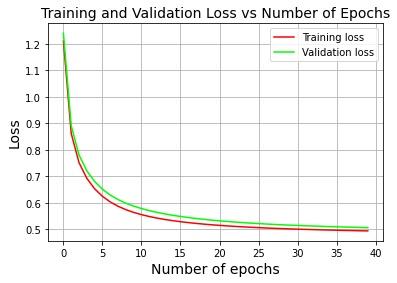

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 8cp3idk9 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: RMSprop


lr_0.001_ac_relu_in_random_normal_op_RMSprop_bs_16_L2_0.5_ep_40_nn_128_nh_3
Epoch number : 2
Training cost:  2.3026170050820207 	Validation cost: 2.3025463797378762
Epoch number : 4
Training cost:  2.302617959196654 	Validation cost: 2.3025457269137197
Epoch number : 6
Training cost:  2.3026179593716245 	Validation cost: 2.3025457267975122
Epoch number : 8
Training cost:  2.3026179593716565 	Validation cost: 2.30254572679749
Epoch number : 10
Training cost:  2.3026179593716574 	Validation cost: 2.30254572679749
Epoch number : 12
Training cost:  2.3026179593716574 	Validation cost: 2.30254572679749
Epoch number : 14
Training cost:  2.3026179593716565 	Validation cost: 2.30254572679749
Epoch number : 16
Training cost:  2.3026179593716565 	Validation cost: 2.30254572679749
Epoch number : 18
Training cost:  2.3026179593716565 	Validation cost: 2.30254572679749
Epoch number : 20
Training cost:  2.3026179593716565 	Validation cost: 2.30254572679749
Epoch number : 22
Training cost:  2.3026179

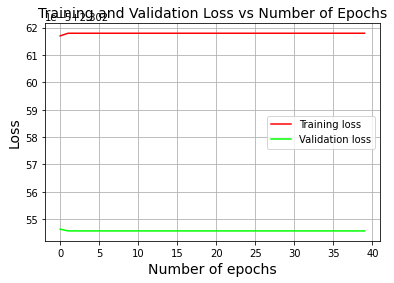

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 1r6gkfje with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum


lr_0.0001_ac_sigmoid_in_random_uniform_op_momentum_bs_16_L2_0.5_ep_10_nn_64_nh_5
Epoch number : 2
Training cost:  2.3026090532692494 	Validation cost: 2.3026738495117414
Epoch number : 4
Training cost:  2.3025905006467835 	Validation cost: 2.302754918434785
Epoch number : 6
Training cost:  2.302588246781699 	Validation cost: 2.3027757407338103
Epoch number : 8
Training cost:  2.302587563769086 	Validation cost: 2.302778770537925
Epoch number : 10
Training cost:  2.302587124236309 	Validation cost: 2.3027772011114966

Final training cost: 2.3025869313259815


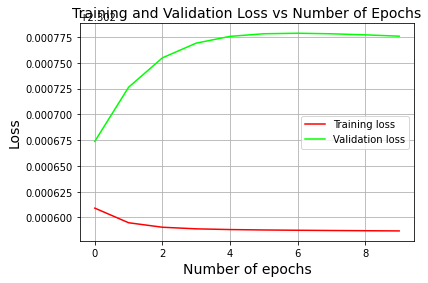

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 3zoqi264 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 512
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.0001_ac_relu_in_random_uniform_op_sgd_bs_512_L2_0_ep_5_nn_128_nh_3
Epoch number : 2
Training cost:  2.301819040019353 	Validation cost: 2.301805646336109
Epoch number : 4
Training cost:  2.2975741544862784 	Validation cost: 2.2972693410646445
Epoch number : 6
Training cost:  2.2938534481974897 	Validation cost: 2.29327921515123

Final training cost: 2.2938534481974897


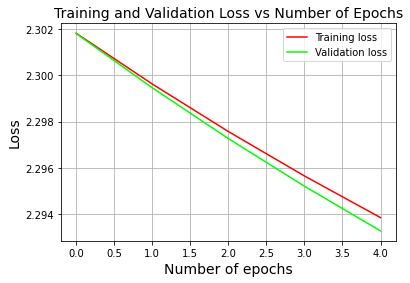

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: xba90jfj with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: nadam


lr_0.0001_ac_sigmoid_in_random_normal_op_nadam_bs_256_L2_0.5_ep_40_nn_32_nh_4
Epoch number : 2
Training cost:  2.302622740442638 	Validation cost: 2.3027422707614904
Epoch number : 4
Training cost:  2.30264303687561 	Validation cost: 2.3027377548220973
Epoch number : 6
Training cost:  2.3026465711975033 	Validation cost: 2.302712961230617
Epoch number : 8
Training cost:  2.3026481739914817 	Validation cost: 2.3026957766711633
Epoch number : 10
Training cost:  2.3026488127510354 	Validation cost: 2.3026828669899917
Epoch number : 12
Training cost:  2.302648939105526 	Validation cost: 2.30267276658065
Epoch number : 14
Training cost:  2.3026487961144553 	Validation cost: 2.3026646963110395
Epoch number : 16
Training cost:  2.302648519624951 	Validation cost: 2.3026581706102003
Epoch number : 18
Training cost:  2.3026481870718367 	Validation cost: 2.302652857361064
Epoch number : 20
Training cost:  2.3026478425350487 	Validation cost: 2.302648515689963
Epoch number : 22
Training cost:  2.

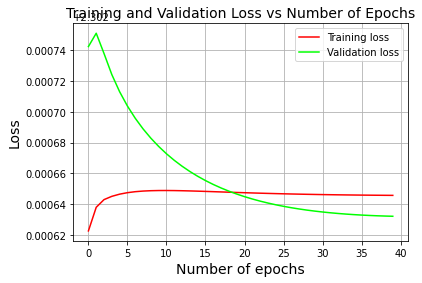

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 4j5kpvnq with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: RMSprop


lr_0.0001_ac_sigmoid_in_xavier_op_RMSprop_bs_128_L2_0.5_ep_5_nn_64_nh_4
Epoch number : 2
Training cost:  2.2989426739294077 	Validation cost: 2.305224452102765
Epoch number : 4
Training cost:  2.2066790534948844 	Validation cost: 2.211080946980181
Epoch number : 6
Training cost:  1.7376538944081465 	Validation cost: 1.7464611993083266

Final training cost: 1.7376538944081465


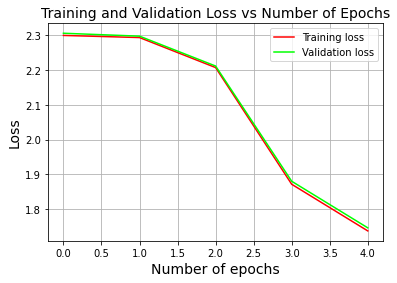

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 6jaes6gc with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.0001_ac_tanh_in_xavier_op_adam_bs_256_L2_0_ep_40_nn_64_nh_3
Epoch number : 2
Training cost:  0.8547745095557648 	Validation cost: 0.8654504517437054
Epoch number : 4
Training cost:  0.4919199156252444 	Validation cost: 0.49765500248799066
Epoch number : 6
Training cost:  0.42792817152430845 	Validation cost: 0.43233692363906506
Epoch number : 8
Training cost:  0.3967054059160125 	Validation cost: 0.4034092611467705
Epoch number : 10
Training cost:  0.37612315732846135 	Validation cost: 0.3862552843625455
Epoch number : 12
Training cost:  0.36075040958912474 	Validation cost: 0.3745017441133303
Epoch number : 14
Training cost:  0.3485537308861988 	Validation cost: 0.36581018080045935
Epoch number : 16
Training cost:  0.33839029042536134 	Validation cost: 0.3590178395052247
Epoch number : 18
Training cost:  0.3295724511858089 	Validation cost: 0.3534993925698897
Epoch number : 20
Training cost:  0.3217404639074765 	Validation cost: 0.34889587274120104
Epoch number : 22
Training cost

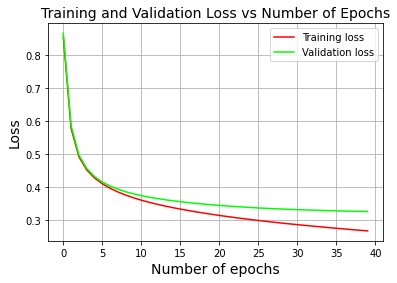

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: kc5vsuxw with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: nestorov


lr_0.001_ac_tanh_in_random_uniform_op_nestorov_bs_64_L2_0.0005_ep_5_nn_32_nh_5
Epoch number : 2
Training cost:  2.302584780354179 	Validation cost: 2.3025847901498158
Epoch number : 4
Training cost:  2.302584780354179 	Validation cost: 2.3025847901498158
Epoch number : 6
Training cost:  2.302584780354179 	Validation cost: 2.3025847901498158

Final training cost: 2.302584780354179


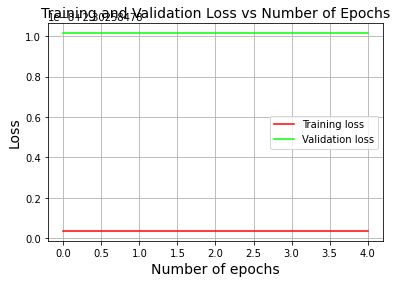

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: ka51xfmz with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 512
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam


lr_0.0001_ac_relu_in_random_normal_op_nadam_bs_512_L2_0.5_ep_40_nn_64_nh_3
Epoch number : 2
Training cost:  2.3025959274320957 	Validation cost: 2.3028171931231425
Epoch number : 4
Training cost:  2.30258290219602 	Validation cost: 2.302825403180807
Epoch number : 6
Training cost:  2.3025655208509974 	Validation cost: 2.3028342977401977
Epoch number : 8
Training cost:  2.3025339097196587 	Validation cost: 2.302826496283874
Epoch number : 10
Training cost:  2.302449188430659 	Validation cost: 2.302760753272
Epoch number : 12
Training cost:  2.3020222522569527 	Validation cost: 2.302347412047831
Epoch number : 14
Training cost:  2.2839259521679147 	Validation cost: 2.283929919529159
Epoch number : 16
Training cost:  1.9158614408063985 	Validation cost: 1.9166502471733378
Epoch number : 18
Training cost:  1.2319376786624523 	Validation cost: 1.2362271508661
Epoch number : 20
Training cost:  1.0514149915335236 	Validation cost: 1.0572467987305758
Epoch number : 22
Training cost:  0.9991911

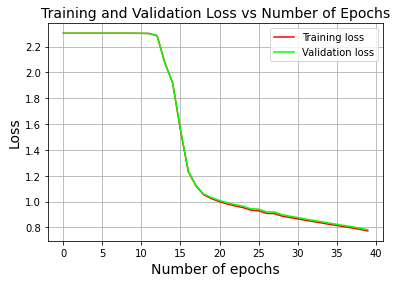

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: dazhzcwp with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.001_ac_relu_in_random_normal_op_sgd_bs_64_L2_0_ep_5_nn_128_nh_3
Epoch number : 2
Training cost:  2.302558042124893 	Validation cost: 2.3025710998302404
Epoch number : 4
Training cost:  2.3025440248182867 	Validation cost: 2.3025788935916727
Epoch number : 6
Training cost:  2.302535922480411 	Validation cost: 2.302589547110372

Final training cost: 2.302535922480411


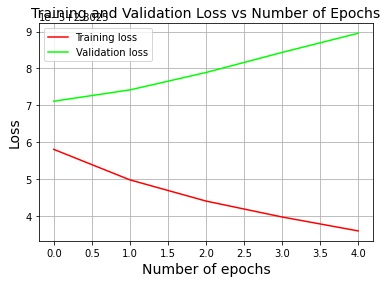

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 1ek6cy3u with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.001_ac_relu_in_random_normal_op_nadam_bs_32_L2_0.5_ep_20_nn_128_nh_3
Epoch number : 2
Training cost:  2.3026989852293784 	Validation cost: 2.302681352997483
Epoch number : 4
Training cost:  2.3027256877120768 	Validation cost: 2.3026295377161374
Epoch number : 6
Training cost:  2.3027263951087136 	Validation cost: 2.302627804497383
Epoch number : 8
Training cost:  2.302726419064718 	Validation cost: 2.3026277483548783
Epoch number : 10
Training cost:  2.3027264198819406 	Validation cost: 2.302627746443031
Epoch number : 12
Training cost:  2.3027264199098294 	Validation cost: 2.3026277463777927
Epoch number : 14
Training cost:  2.302726419910781 	Validation cost: 2.302627746375566
Epoch number : 16
Training cost:  2.302726419910814 	Validation cost: 2.30262774637549
Epoch number : 18
Training cost:  2.302726419910814 	Validation cost: 2.3026277463754874
Epoch number : 20
Training cost:  2.3027264199108144 	Validation cost: 2.302627746375487

Final training cost: 2.3027264199108144


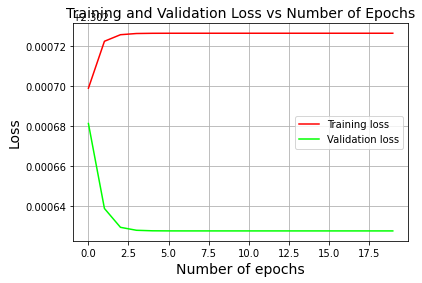

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: pnahieaw with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd


lr_0.001_ac_tanh_in_xavier_op_sgd_bs_16_L2_0_ep_5_nn_64_nh_5
Epoch number : 2
Training cost:  0.8388312426684892 	Validation cost: 0.843504805594717
Epoch number : 4
Training cost:  0.57869926149843 	Validation cost: 0.5813302298974068
Epoch number : 6
Training cost:  0.49963023981539595 	Validation cost: 0.5027027824575092

Final training cost: 0.49963023981539595


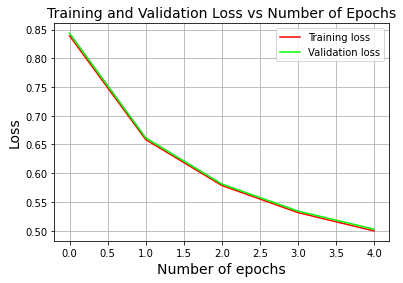

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: g6k5zyrb with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: RMSprop


lr_0.001_ac_tanh_in_xavier_op_RMSprop_bs_128_L2_0.0005_ep_5_nn_32_nh_5
Epoch number : 2
Training cost:  0.4472748470967968 	Validation cost: 0.45431141649098306
Epoch number : 4
Training cost:  0.36135860393297176 	Validation cost: 0.3831727906750119
Epoch number : 6
Training cost:  0.33216957697608673 	Validation cost: 0.3669034756488635

Final training cost: 0.33216957697608673


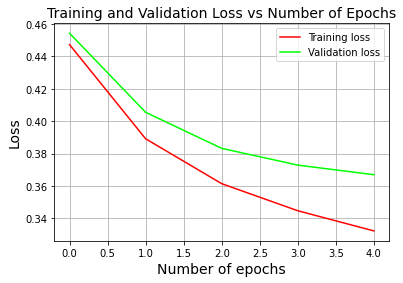

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: o0fhvk8b with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam


lr_0.001_ac_sigmoid_in_random_normal_op_nadam_bs_32_L2_0.5_ep_5_nn_64_nh_4
Epoch number : 2
Training cost:  2.315649247000972 	Validation cost: 2.3165092541439782
Epoch number : 4
Training cost:  2.310261176360621 	Validation cost: 2.310589251585568
Epoch number : 6
Training cost:  2.3072333097182027 	Validation cost: 2.3071376608222587

Final training cost: 2.3072333097182027


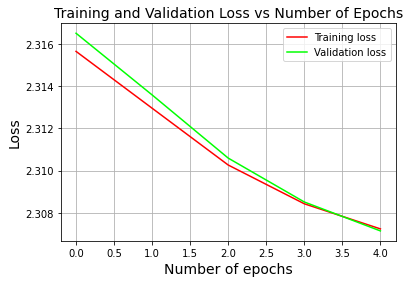

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: f8y05rh3 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 512
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: RMSprop


lr_0.0001_ac_tanh_in_xavier_op_RMSprop_bs_512_L2_0.0005_ep_5_nn_64_nh_5
Epoch number : 2
Training cost:  1.0028442882078512 	Validation cost: 1.0116407188415892
Epoch number : 4
Training cost:  0.5841657904395426 	Validation cost: 0.5890162858965063
Epoch number : 6
Training cost:  0.48406123163004644 	Validation cost: 0.4884159328241678

Final training cost: 0.48406123163004644


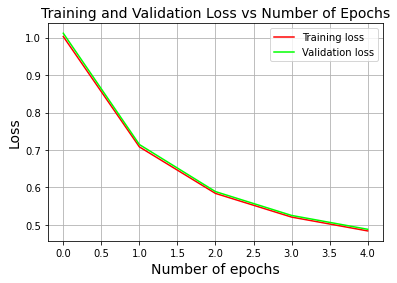

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: d2262o9w with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: nestorov


lr_0.001_ac_tanh_in_random_uniform_op_nestorov_bs_32_L2_0_ep_10_nn_64_nh_3
Epoch number : 2
Training cost:  2.3026813956364216 	Validation cost: 2.302697574142683
Epoch number : 4
Training cost:  2.3026813956364216 	Validation cost: 2.302697574142683
Epoch number : 6
Training cost:  2.3026813956364216 	Validation cost: 2.302697574142683
Epoch number : 8
Training cost:  2.3026813956364216 	Validation cost: 2.302697574142683
Epoch number : 10
Training cost:  2.3026813956364216 	Validation cost: 2.302697574142683

Final training cost: 2.3026813956364216


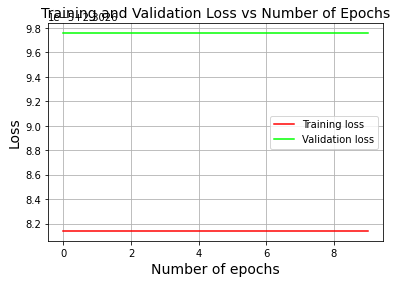

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: vxg6jnmm with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: sgd


lr_0.0001_ac_relu_in_xavier_op_sgd_bs_16_L2_0.0005_ep_40_nn_64_nh_5
Epoch number : 2
Training cost:  2.266394271430515 	Validation cost: 2.2679091449288653
Epoch number : 4
Training cost:  2.1251493432608055 	Validation cost: 2.12708466263354
Epoch number : 6
Training cost:  1.8240841722215724 	Validation cost: 1.8250300026313433
Epoch number : 8
Training cost:  1.3750737114284874 	Validation cost: 1.3778999679631039
Epoch number : 10
Training cost:  1.0635629854098811 	Validation cost: 1.0715713627710532
Epoch number : 12
Training cost:  0.9129844138549434 	Validation cost: 0.9231764438834076
Epoch number : 14
Training cost:  0.8341518595234161 	Validation cost: 0.844634813037108
Epoch number : 16
Training cost:  0.7873248478210518 	Validation cost: 0.7975253681080595
Epoch number : 18
Training cost:  0.7551352708165241 	Validation cost: 0.7647824730199445
Epoch number : 20
Training cost:  0.7284527613894946 	Validation cost: 0.7376583303374541
Epoch number : 22
Training cost:  0.7067

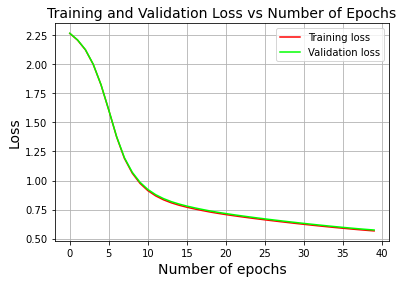

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 26vs5kkf with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 20
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: RMSprop


lr_0.001_ac_sigmoid_in_random_normal_op_RMSprop_bs_32_L2_0_ep_20_nn_128_nh_5
Epoch number : 2
Training cost:  2.3025982395058997 	Validation cost: 2.3025943121753394
Epoch number : 4
Training cost:  2.30259644918937 	Validation cost: 2.3026112686824804
Epoch number : 6
Training cost:  2.3025964335371945 	Validation cost: 2.302611375614682
Epoch number : 8
Training cost:  2.3025964287717113 	Validation cost: 2.30261139551556
Epoch number : 10
Training cost:  2.302596425696238 	Validation cost: 2.3026114040395824
Epoch number : 12
Training cost:  2.3025964230241676 	Validation cost: 2.3026114080711815
Epoch number : 14
Training cost:  2.3025964202195928 	Validation cost: 2.3026114096509387
Epoch number : 16
Training cost:  2.3025964168689645 	Validation cost: 2.3026114094620462
Epoch number : 18
Training cost:  2.3025964124387044 	Validation cost: 2.3026114075648594
Epoch number : 20
Training cost:  2.302596405978706 	Validation cost: 2.3026114034673526

Final training cost: 2.3025964014

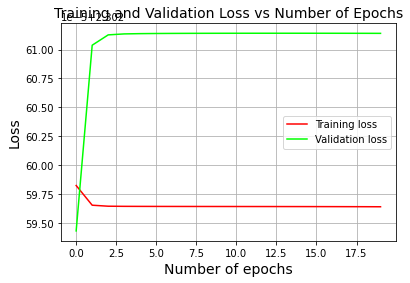

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 16p17lxw with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: nadam


lr_0.0001_ac_relu_in_random_normal_op_nadam_bs_64_L2_0_ep_10_nn_64_nh_5
Epoch number : 2
Training cost:  2.302587494834522 	Validation cost: 2.3025847895369767
Epoch number : 4
Training cost:  2.3026210443006345 	Validation cost: 2.3026551934529613
Epoch number : 6
Training cost:  2.3026756631510867 	Validation cost: 2.3027368176631753
Epoch number : 8
Training cost:  2.302721692971739 	Validation cost: 2.302797296445161
Epoch number : 10
Training cost:  2.302753728841291 	Validation cost: 2.302835873528102

Final training cost: 2.302765252747902


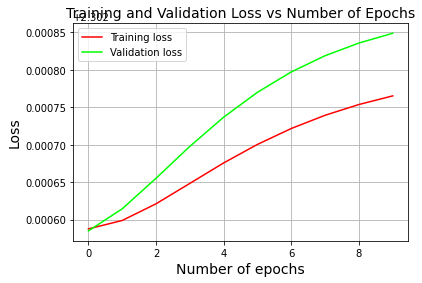

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: z09jezbi with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 128
wandb: 	epochs: 10
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd


lr_0.0001_ac_sigmoid_in_xavier_op_sgd_bs_128_L2_0_ep_10_nn_32_nh_3
Epoch number : 2
Training cost:  2.475297490698251 	Validation cost: 2.4734442172205138
Epoch number : 4
Training cost:  2.447996639592691 	Validation cost: 2.4462751318200815
Epoch number : 6
Training cost:  2.4252062145007938 	Validation cost: 2.4236001185018057
Epoch number : 8
Training cost:  2.4060612562264856 	Validation cost: 2.4045596636065336
Epoch number : 10
Training cost:  2.3899107217767317 	Validation cost: 2.388505979171181

Final training cost: 2.382795733870553


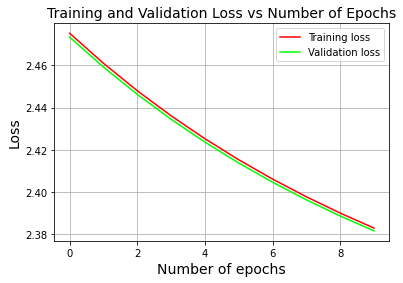

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: k9typ4tw with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: adam


lr_0.0001_ac_relu_in_random_normal_op_adam_bs_32_L2_0.5_ep_10_nn_64_nh_3
Epoch number : 2
Training cost:  2.3025831974210615 	Validation cost: 2.3026277507859714
Epoch number : 4
Training cost:  2.302590897636165 	Validation cost: 2.3027549072637425
Epoch number : 6
Training cost:  2.302601597440973 	Validation cost: 2.3028311272651196
Epoch number : 8
Training cost:  2.3026084009172973 	Validation cost: 2.302874247415964
Epoch number : 10
Training cost:  2.302612358567261 	Validation cost: 2.3028993393081216

Final training cost: 2.3026136630079965


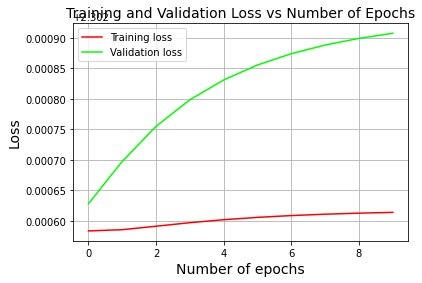

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ieiz2h9s with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 5
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: adam


lr_0.0001_ac_tanh_in_random_normal_op_adam_bs_128_L2_0_ep_5_nn_128_nh_3
Epoch number : 2
Training cost:  2.144911241223428 	Validation cost: 2.14542969638328
Epoch number : 4
Training cost:  0.9544637323613246 	Validation cost: 0.9633052490014842
Epoch number : 6
Training cost:  0.6236142153340568 	Validation cost: 0.6310452981238753

Final training cost: 0.6236142153340568


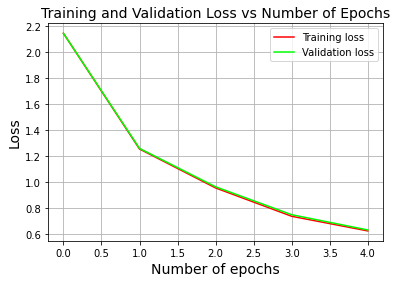

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 5echdhlw with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 512
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.001_ac_tanh_in_xavier_op_nadam_bs_512_L2_0.5_ep_5_nn_128_nh_5
Epoch number : 2
Training cost:  0.6170606075917637 	Validation cost: 0.6488589875485524
Epoch number : 4
Training cost:  0.49982222904385476 	Validation cost: 0.5309137313531169
Epoch number : 6
Training cost:  0.4538617042753224 	Validation cost: 0.48707599324110085

Final training cost: 0.4538617042753224


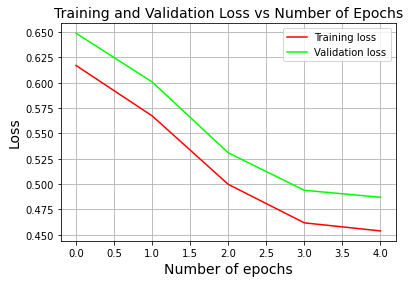

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: yd5m96za with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: tanh
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: adam


lr_0.001_ac_tanh_in_random_normal_op_adam_bs_128_L2_0_ep_40_nn_128_nh_5
Epoch number : 2
Training cost:  2.3026261818771765 	Validation cost: 2.302460026841521
Epoch number : 4
Training cost:  2.3026554390487326 	Validation cost: 2.302382596822631
Epoch number : 6
Training cost:  1.57642456839796 	Validation cost: 1.5830675905191764
Epoch number : 8
Training cost:  0.6186769041003495 	Validation cost: 0.6212834798769132
Epoch number : 10
Training cost:  0.5125006555301976 	Validation cost: 0.5321853933086982
Epoch number : 12
Training cost:  0.4813124271768484 	Validation cost: 0.5086092373676938
Epoch number : 14
Training cost:  0.40927819197488435 	Validation cost: 0.4472447891914121
Epoch number : 16
Training cost:  0.4028885201830038 	Validation cost: 0.45279132058875365
Epoch number : 18
Training cost:  0.3549697407626324 	Validation cost: 0.4178797859116177
Epoch number : 20
Training cost:  0.33204146194978124 	Validation cost: 0.40540004270578317
Epoch number : 22
Training cost:

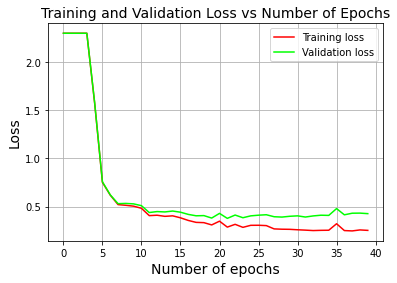

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 5a2zxwqh with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum


lr_0.001_ac_sigmoid_in_xavier_op_momentum_bs_16_L2_0.0005_ep_40_nn_64_nh_4
Epoch number : 2
Training cost:  2.3017030314679623 	Validation cost: 2.3015127964494417
Epoch number : 4
Training cost:  2.301248044585231 	Validation cost: 2.301053185973615
Epoch number : 6
Training cost:  2.3007594200155617 	Validation cost: 2.3005648887598538
Epoch number : 8
Training cost:  2.300223416575356 	Validation cost: 2.30002969275998
Epoch number : 10
Training cost:  2.299620845968021 	Validation cost: 2.299428544931265
Epoch number : 12
Training cost:  2.2989264447476447 	Validation cost: 2.298736372925591
Epoch number : 14
Training cost:  2.2981056530524895 	Validation cost: 2.297918892762048
Epoch number : 16
Training cost:  2.2971093981507136 	Validation cost: 2.296927439160258
Epoch number : 18
Training cost:  2.2958652886357607 	Validation cost: 2.295690238917538
Epoch number : 20
Training cost:  2.294262071342952 	Validation cost: 2.2940970084120704
Epoch number : 22
Training cost:  2.29212

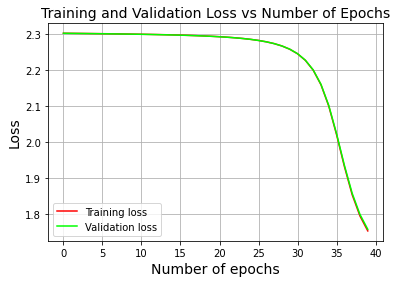

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: zztg633n with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: adam


lr_0.0001_ac_relu_in_random_uniform_op_adam_bs_64_L2_0.0005_ep_5_nn_32_nh_4
Epoch number : 2
Training cost:  2.0980834758194997 	Validation cost: 2.0910453967282225
Epoch number : 4
Training cost:  1.7723531523725384 	Validation cost: 1.7561528522147576
Epoch number : 6
Training cost:  1.6184298791574092 	Validation cost: 1.6045116146452196

Final training cost: 1.6184298791574092


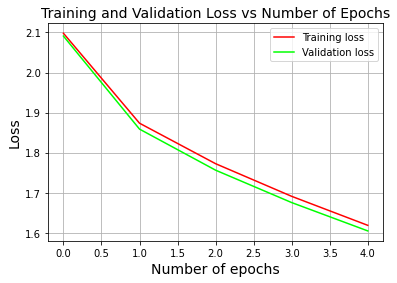

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: lctmnij4 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 128
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: RMSprop


lr_0.0001_ac_relu_in_random_uniform_op_RMSprop_bs_128_L2_0_ep_40_nn_128_nh_5
Epoch number : 2
Training cost:  1.9093023147645194 	Validation cost: 1.8974051990088077
Epoch number : 4
Training cost:  nan 	Validation cost: 1.8182947174836488
Epoch number : 6
Training cost:  nan 	Validation cost: nan
Epoch number : 8
Training cost:  nan 	Validation cost: nan
Epoch number : 10
Training cost:  nan 	Validation cost: nan
Epoch number : 12
Training cost:  nan 	Validation cost: nan
Epoch number : 14
Training cost:  nan 	Validation cost: nan
Epoch number : 16
Training cost:  nan 	Validation cost: nan
Epoch number : 18
Training cost:  nan 	Validation cost: nan
Epoch number : 20
Training cost:  nan 	Validation cost: nan
Epoch number : 22
Training cost:  nan 	Validation cost: nan
Epoch number : 24
Training cost:  nan 	Validation cost: nan
Epoch number : 26
Training cost:  nan 	Validation cost: nan
Epoch number : 28
Training cost:  nan 	Validation cost: nan
Epoch number : 30
Training cost:  nan 	Val

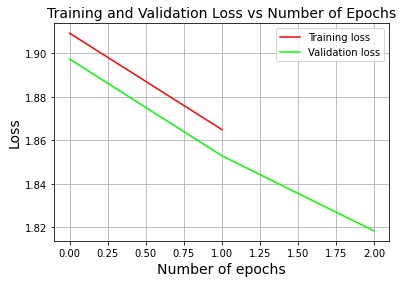

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: l2fw8bpr with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 256
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum


lr_0.0001_ac_sigmoid_in_random_uniform_op_momentum_bs_256_L2_0_ep_40_nn_128_nh_4
Epoch number : 2
Training cost:  2.3027946485722133 	Validation cost: 2.302692246324175
Epoch number : 4
Training cost:  2.3027243916438804 	Validation cost: 2.3026672648733006
Epoch number : 6
Training cost:  2.3026769112123207 	Validation cost: 2.302657015074287
Epoch number : 8
Training cost:  2.3026448195748768 	Validation cost: 2.302655522940203
Epoch number : 10
Training cost:  2.3026231249745233 	Validation cost: 2.3026589672368662
Epoch number : 12
Training cost:  2.3026084550301973 	Validation cost: 2.3026649429866843
Epoch number : 14
Training cost:  2.3025985316063213 	Validation cost: 2.302671970412722
Epoch number : 16
Training cost:  2.3025918158301164 	Validation cost: 2.302679168713535
Epoch number : 18
Training cost:  2.3025872681960196 	Validation cost: 2.302686040297388
Epoch number : 20
Training cost:  2.302584186483988 	Validation cost: 2.3026923288554753
Epoch number : 22
Training cos

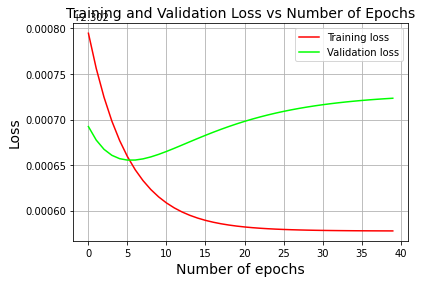

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: mt5cyb53 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: relu
wandb: 	batch_size: 512
wandb: 	epochs: 20
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum


lr_0.0001_ac_relu_in_random_normal_op_momentum_bs_512_L2_0.5_ep_20_nn_128_nh_3
Epoch number : 2
Training cost:  2.3026383633903054 	Validation cost: 2.303137677557751
Epoch number : 4
Training cost:  2.3026374733957744 	Validation cost: 2.303137090432313
Epoch number : 6
Training cost:  2.3026366160796847 	Validation cost: 2.3031365336425176
Epoch number : 8
Training cost:  2.3026357979134415 	Validation cost: 2.303136011687385
Epoch number : 10
Training cost:  2.3026350206201167 	Validation cost: 2.303135527412873
Epoch number : 12
Training cost:  2.3026342793472883 	Validation cost: 2.3031350807513675
Epoch number : 14
Training cost:  2.302633571036323 	Validation cost: 2.3031346671705766
Epoch number : 16
Training cost:  2.302632894503072 	Validation cost: 2.30313428395282
Epoch number : 18
Training cost:  2.302632248034562 	Validation cost: 2.303133930377089
Epoch number : 20
Training cost:  2.3026316314764737 	Validation cost: 2.3031336060409324

Final training cost: 2.30263133385

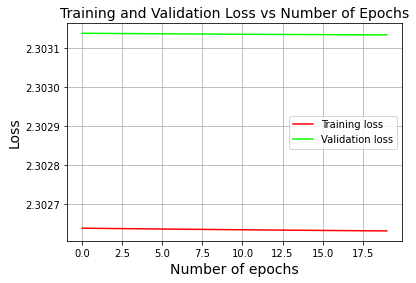

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 0oezcubs with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 64
wandb: 	optimizer: RMSprop


lr_0.0001_ac_sigmoid_in_random_normal_op_RMSprop_bs_16_L2_0_ep_40_nn_64_nh_4
Epoch number : 2
Training cost:  2.3028161482953817 	Validation cost: 2.302436902610338
Epoch number : 4
Training cost:  2.198251551311137 	Validation cost: 2.1979830722182667
Epoch number : 6
Training cost:  1.5454980716768865 	Validation cost: 1.5523080157586024
Epoch number : 8
Training cost:  1.3376932187590027 	Validation cost: 1.3403423030941846
Epoch number : 10
Training cost:  1.1095101557931175 	Validation cost: 1.108289774416181
Epoch number : 12
Training cost:  0.9508840296970552 	Validation cost: 0.9507543988599692
Epoch number : 14
Training cost:  0.8672581499121401 	Validation cost: 0.8690988809317375
Epoch number : 16
Training cost:  0.8179523335521347 	Validation cost: 0.8231122428965016
Epoch number : 18
Training cost:  0.7651841287504174 	Validation cost: 0.7745007059628563
Epoch number : 20
Training cost:  0.7280683750269284 	Validation cost: 0.740627866038953
Epoch number : 22
Training cost

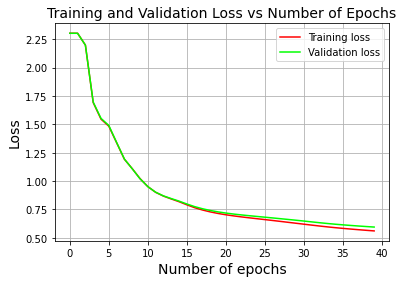

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 4pwbjh7g with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 32
wandb: 	optimizer: nestorov


lr_0.001_ac_tanh_in_random_uniform_op_nestorov_bs_256_L2_0.5_ep_20_nn_32_nh_3
Epoch number : 2
Training cost:  2.302605491335606 	Validation cost: 2.3026383234605285
Epoch number : 4
Training cost:  2.302605491335606 	Validation cost: 2.3026383234605285
Epoch number : 6
Training cost:  2.302605491335606 	Validation cost: 2.3026383234605285
Epoch number : 8
Training cost:  2.302605491335606 	Validation cost: 2.3026383234605285
Epoch number : 10
Training cost:  2.302605491335606 	Validation cost: 2.3026383234605285
Epoch number : 12
Training cost:  2.302605491335606 	Validation cost: 2.3026383234605285
Epoch number : 14
Training cost:  2.302605491335606 	Validation cost: 2.3026383234605285
Epoch number : 16
Training cost:  2.302605491335606 	Validation cost: 2.3026383234605285
Epoch number : 18
Training cost:  2.302605491335606 	Validation cost: 2.3026383234605285
Epoch number : 20
Training cost:  2.302605491335606 	Validation cost: 2.3026383234605285

Final training cost: 2.302605491335

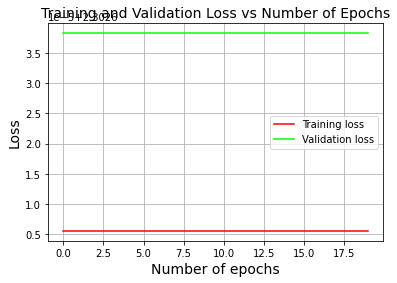

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 7k0v3zlw with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 10
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 128
wandb: 	optimizer: sgd


lr_0.0001_ac_tanh_in_random_uniform_op_sgd_bs_256_L2_0.5_ep_10_nn_128_nh_4
Epoch number : 2
Training cost:  2.3024028327225587 	Validation cost: 2.3025374490161594
Epoch number : 4
Training cost:  2.302069063147501 	Validation cost: 2.3021787452189844
Epoch number : 6
Training cost:  2.3017463324375096 	Validation cost: 2.301831594294984
Epoch number : 8
Training cost:  2.3014340644915876 	Validation cost: 2.301495402816073
Epoch number : 10
Training cost:  2.3011317211097615 	Validation cost: 2.3011696162715816

Final training cost: 2.300984112517715


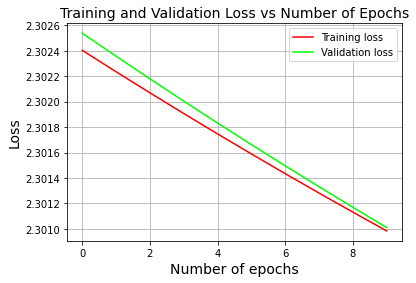

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: nisqat8v with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: nestorov


lr_0.0001_ac_tanh_in_xavier_op_nestorov_bs_32_L2_0.0005_ep_40_nn_128_nh_3
Epoch number : 2
Training cost:  2.4390336343481107 	Validation cost: 2.449137733927176
Epoch number : 4
Training cost:  2.4390336343481107 	Validation cost: 2.449137733927176
Epoch number : 6
Training cost:  2.4390336343481107 	Validation cost: 2.449137733927176
Epoch number : 8
Training cost:  2.4390336343481107 	Validation cost: 2.449137733927176
Epoch number : 10
Training cost:  2.4390336343481107 	Validation cost: 2.449137733927176
Epoch number : 12
Training cost:  2.4390336343481107 	Validation cost: 2.449137733927176
Epoch number : 14
Training cost:  2.4390336343481107 	Validation cost: 2.449137733927176
Epoch number : 16
Training cost:  2.4390336343481107 	Validation cost: 2.449137733927176
Epoch number : 18
Training cost:  2.4390336343481107 	Validation cost: 2.449137733927176
Epoch number : 20
Training cost:  2.4390336343481107 	Validation cost: 2.449137733927176
Epoch number : 22
Training cost:  2.4390

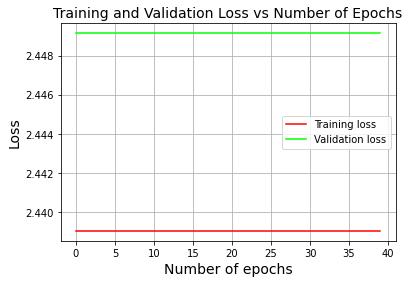

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 1h5fwuip with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: tanh
wandb: 	batch_size: 32
wandb: 	epochs: 40
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum


lr_0.0001_ac_tanh_in_random_uniform_op_momentum_bs_32_L2_0.0005_ep_40_nn_64_nh_5
Epoch number : 2
Training cost:  2.302576582026828 	Validation cost: 2.3025777829295975
Epoch number : 4
Training cost:  2.3025725678054263 	Validation cost: 2.3025787156753648
Epoch number : 6
Training cost:  2.3025685834088634 	Validation cost: 2.3025795111389913
Epoch number : 8
Training cost:  2.302564626128827 	Validation cost: 2.3025801721255634
Epoch number : 10
Training cost:  2.3025606933914298 	Validation cost: 2.3025807013915127
Epoch number : 12
Training cost:  2.3025567827480553 	Validation cost: 2.3025811016414504
Epoch number : 14
Training cost:  2.3025528918667812 	Validation cost: 2.302581375525384
Epoch number : 16
Training cost:  2.302549018524335 	Validation cost: 2.302581525636287
Epoch number : 18
Training cost:  2.302545160598552 	Validation cost: 2.302581554507984
Epoch number : 20
Training cost:  2.3025413160613093 	Validation cost: 2.302581464613334
Epoch number : 22
Training cost

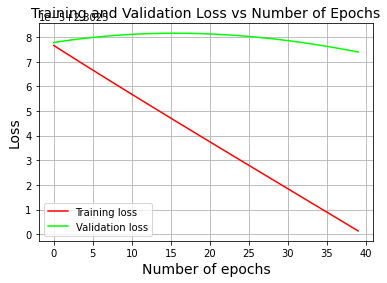

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: acf2vwt0 with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum


lr_0.001_ac_sigmoid_in_xavier_op_momentum_bs_16_L2_0.0005_ep_20_nn_128_nh_3
Epoch number : 2
Training cost:  2.298588889461461 	Validation cost: 2.298281175139315
Epoch number : 4
Training cost:  2.288283306054293 	Validation cost: 2.2880799660666917
Epoch number : 6
Training cost:  2.2745369471795764 	Validation cost: 2.2744648159905676
Epoch number : 8
Training cost:  2.2523418912139705 	Validation cost: 2.2524735797372104
Epoch number : 10
Training cost:  2.208882788079526 	Validation cost: 2.209417033534432
Epoch number : 12
Training cost:  2.1083860333379554 	Validation cost: 2.1098731504385593
Epoch number : 14
Training cost:  1.9030161776057875 	Validation cost: 1.9062463893494688
Epoch number : 16
Training cost:  1.6914982081491927 	Validation cost: 1.695638997215888
Epoch number : 18
Training cost:  1.542805733423965 	Validation cost: 1.5466695584527779
Epoch number : 20
Training cost:  1.418411273939482 	Validation cost: 1.4217306545430584

Final training cost: 1.362839458000

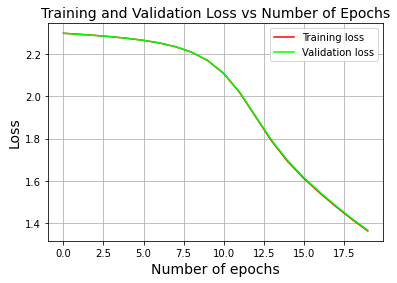

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 1bz0geu6 with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 4
wandb: 	num_neurons: 32
wandb: 	optimizer: sgd


lr_0.0001_ac_relu_in_xavier_op_sgd_bs_16_L2_0_ep_5_nn_32_nh_4
Epoch number : 2
Training cost:  2.2818589907131632 	Validation cost: 2.2798589668173865
Epoch number : 4
Training cost:  2.2087696634981433 	Validation cost: 2.2082669995960247
Epoch number : 6
Training cost:  2.101498269246811 	Validation cost: 2.1027868485575865

Final training cost: 2.101498269246811


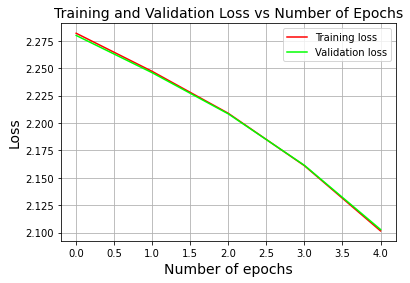

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 4u3bmii9 with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 512
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: adam


lr_0.001_ac_sigmoid_in_xavier_op_adam_bs_512_L2_0.5_ep_5_nn_128_nh_5
Epoch number : 2
Training cost:  2.3091054120961534 	Validation cost: 2.3310109690242187
Epoch number : 4
Training cost:  2.3096154673356377 	Validation cost: 2.32523602267723
Epoch number : 6
Training cost:  2.309227775336591 	Validation cost: 2.3202088400941783

Final training cost: 2.309227775336591


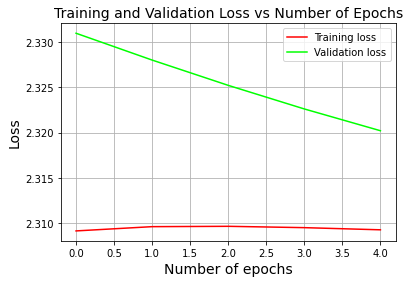

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: grvk96us with config:
wandb: 	L2_lamb: 0.5
wandb: 	activation_f: tanh
wandb: 	batch_size: 256
wandb: 	epochs: 5
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 32
wandb: 	optimizer: nestorov


lr_0.001_ac_tanh_in_random_normal_op_nestorov_bs_256_L2_0.5_ep_5_nn_32_nh_5
Epoch number : 2
Training cost:  2.302598693360033 	Validation cost: 2.302707572168138
Epoch number : 4
Training cost:  2.302598693360033 	Validation cost: 2.302707572168138
Epoch number : 6
Training cost:  2.302598693360033 	Validation cost: 2.302707572168138

Final training cost: 2.302598693360033


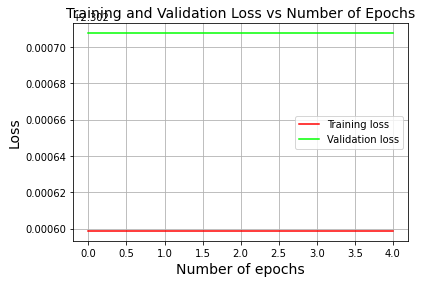

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: yjpmwh9r with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: relu
wandb: 	batch_size: 32
wandb: 	epochs: 5
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 64
wandb: 	optimizer: momentum


lr_0.0001_ac_relu_in_xavier_op_momentum_bs_32_L2_0.0005_ep_5_nn_64_nh_5
Epoch number : 2
Training cost:  2.2944719990148523 	Validation cost: 2.2964523244392168
Epoch number : 4
Training cost:  2.23966037032661 	Validation cost: 2.241263902508832
Epoch number : 6
Training cost:  2.171097514106653 	Validation cost: 2.1730467148991512

Final training cost: 2.171097514106653


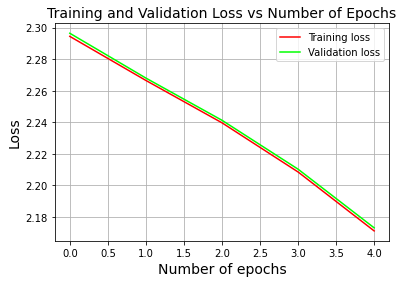

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 054u78cu with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: relu
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init_mode: xavier
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: momentum


lr_0.001_ac_relu_in_xavier_op_momentum_bs_64_L2_0_ep_20_nn_128_nh_5
Epoch number : 2
Training cost:  2.0444996932056916 	Validation cost: 2.041799255842166
Epoch number : 4
Training cost:  1.0059221085830654 	Validation cost: 1.0169499610713026
Epoch number : 6
Training cost:  0.7872143645339748 	Validation cost: 0.798230441139343
Epoch number : 8
Training cost:  0.6961516524919483 	Validation cost: 0.7062174166083118
Epoch number : 10
Training cost:  0.6311213950622425 	Validation cost: 0.6415461472568187
Epoch number : 12
Training cost:  0.5828406504003124 	Validation cost: 0.593466190318074
Epoch number : 14
Training cost:  0.5470343379897954 	Validation cost: 0.5579261084713896
Epoch number : 16
Training cost:  0.5202020704018253 	Validation cost: 0.5311284590217668
Epoch number : 18
Training cost:  0.4997398156572141 	Validation cost: 0.5107913944338214
Epoch number : 20
Training cost:  0.4836422661239896 	Validation cost: 0.49480172502208913

Final training cost: 0.47686192843786

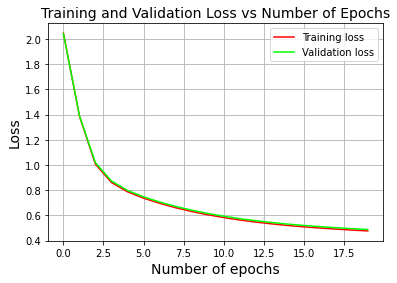

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: cvv4gl4b with config:
wandb: 	L2_lamb: 0
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 40
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 5
wandb: 	num_neurons: 128
wandb: 	optimizer: nadam


lr_0.0001_ac_sigmoid_in_random_normal_op_nadam_bs_16_L2_0_ep_40_nn_128_nh_5
Epoch number : 2
Training cost:  2.3075193358277817 	Validation cost: 2.3074411091006026
Epoch number : 4
Training cost:  2.303533409276626 	Validation cost: 2.3033471012910756
Epoch number : 6
Training cost:  2.3030305397315387 	Validation cost: 2.3029035016944692
Epoch number : 8
Training cost:  2.3028838230663755 	Validation cost: 2.302802058068082
Epoch number : 10
Training cost:  2.302823538035958 	Validation cost: 2.302769697920128
Epoch number : 12
Training cost:  2.302797418641321 	Validation cost: 2.302756203109803
Epoch number : 14
Training cost:  2.3027880517423855 	Validation cost: 2.3027485074194733
Epoch number : 16
Training cost:  2.3027879851717192 	Validation cost: 2.3027425335190372
Epoch number : 18
Training cost:  2.3027936029261227 	Validation cost: 2.302736562437405
Epoch number : 20
Training cost:  2.3028030844690113 	Validation cost: 2.3027298629480297
Epoch number : 22
Training cost:  2

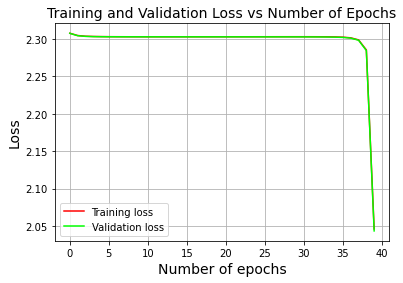

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: 023xa4wy with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 32
wandb: 	epochs: 10
wandb: 	init_mode: random_normal
wandb: 	learning_rate: 0.001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 128
wandb: 	optimizer: adam


lr_0.001_ac_sigmoid_in_random_normal_op_adam_bs_32_L2_0.0005_ep_10_nn_128_nh_3
Epoch number : 2
Training cost:  1.7600684020149968 	Validation cost: 1.7688064271109696
Epoch number : 4
Training cost:  0.675646600904687 	Validation cost: 0.6859241215260595
Epoch number : 6
Training cost:  0.44220203873571273 	Validation cost: 0.4509387199890674
Epoch number : 8
Training cost:  0.4020505817017842 	Validation cost: 0.4222729561758472
Epoch number : 10
Training cost:  0.3921981008881859 	Validation cost: 0.4198734135150745

Final training cost: 0.39226449034952215


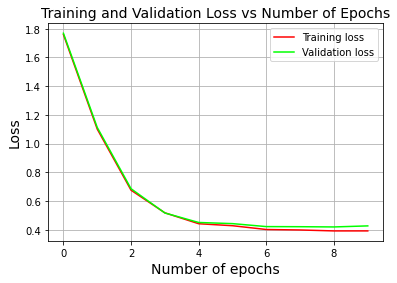

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


wandb: Agent Starting Run: br7spa3l with config:
wandb: 	L2_lamb: 0.0005
wandb: 	activation_f: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 20
wandb: 	init_mode: random_uniform
wandb: 	learning_rate: 0.0001
wandb: 	num_hidden: 3
wandb: 	num_neurons: 64
wandb: 	optimizer: RMSprop


lr_0.0001_ac_sigmoid_in_random_uniform_op_RMSprop_bs_64_L2_0.0005_ep_20_nn_64_nh_3
Epoch number : 2
Training cost:  2.3026471040932326 	Validation cost: 2.3024929185729603
Epoch number : 4
Training cost:  2.0125356731150026 	Validation cost: 2.0160536873929753
Epoch number : 6
Training cost:  1.668076430099603 	Validation cost: 1.672950361135608
Epoch number : 8
Training cost:  1.4513308203389381 	Validation cost: 1.4556907894171258
Epoch number : 10
Training cost:  1.2869001214744529 	Validation cost: 1.288697235989297
Epoch number : 12
Training cost:  1.1793877923697602 	Validation cost: 1.1809148929272548
Epoch number : 14
Training cost:  1.0879534095061967 	Validation cost: 1.087764156840061
Epoch number : 16
Training cost:  1.0040549960241567 	Validation cost: 1.003859333395488
Epoch number : 18
Training cost:  0.9349682473723809 	Validation cost: 0.9364142281593576
Epoch number : 20
Training cost:  0.8818901527956593 	Validation cost: 0.8856515114339931

Final training cost: 0.86

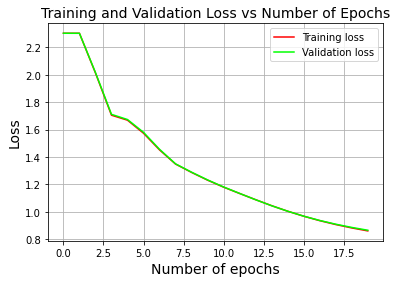

wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


In [19]:
sweep_config = {
  "name": "CS6910 Assignment 1 - Cross Entropy Loss",
  "metric": {
      "name":"validation_accuracy",
      "goal": "maximize"
  },
  "method": "random",
  "parameters": {
        "learning_rate": {
            "values": [0.001, 0.0001]
        },
        "activation_f": {
            "values": ["sigmoid", "relu", "tanh"]
        },
        "init_mode": {
            "values": ["xavier", "random_uniform", "random_normal"]
        },
        "optimizer": {
            "values": ["sgd", "momentum", "nestorov", "adam", "nadam", "RMSprop"]
        },
        "batch_size": {
            "values": [16,32,64,128,256,512]
        },
        "epochs": {
            "values": [5, 10, 20, 40]
        },
        "L2_lamb": {
            "values": [0, 0.0005, 0.5]
        },
        "num_neurons": {
            "values": [32, 64, 128]
        },
        "num_hidden": {
            "values": [3, 4, 5]
        }
    }
}

sweep_id = wandb.sweep(sweep_config, entity="ee17b154tony", project="dl_assignment1")
wandb.agent(sweep_id, NN_fit, count=120)

# Training the model with the best combination of hyperparameters

#### Setting Hyperparameters based on wandb results

These are the best choices for hyperparameters chosen using wandb.ai's sweep feature

In [38]:
LEARNING_RATE = 0.001
ACTIVATION = "relu"
INITIALIZER = "xavier"
OPTIMIZER = "RMSprop"
BATCH_SIZE = 512
EPOCHS = 40
L2_lambda = 0.0005
NUM_NEURONS = 128
NUM_HIDDEN = 3

LOSS = 'categorical_crossentropy'

#### Training on the full dataset

In [41]:
def NN_best_fit(X_train, y_train_one_hot, learning_rate = 0.001, activation_f = 'tanh', init_mode = 'xavier', 
                optimizer = 'adam', batch_size = 512, loss = 'categorical_crossentropy', epochs = 20, L2_lamb = 0,
                num_neurons = 64, num_hidden = 3):
    """
    This function is used to train the neural network on the full dataset given the best set of hyperparameter values
    """
    #Layer sizes
    layer_dims = [num_features] + [num_neurons]*num_hidden + [num_classes]

    params, previous_updates = initialize_parameters(layer_dims, init_mode) # initialize the parameters and past updates matrices
    
    epoch_cost = []
    
    count = 1
    t = 1 # initialize timestep for Adam optimizer
    v = previous_updates.copy()
    m = previous_updates.copy()
    params_look_ahead = params.copy() # initialization for nestorov
    beta = 0.9
    loss = 'categorical_crossentropy'    

    while count<=epochs:
        count = count + 1 # increment the number of epochs
        for i in range(0, X_train.shape[1], batch_size):
            batch_count = batch_size
            if i + batch_size > X_train.shape[1]: # the last mini-batch might contain fewer than "batch_size" examples
                batch_count = X_train.shape[1] - i + 1

            if optimizer == 'nesterov':
                L = len(params)//2
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]
                    
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, loss, L2_lamb)
                params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                
            elif optimizer=='nadam':
                L = len(params)//2
                for l in range(1, L+1):
                    params_look_ahead["W"+str(l)] = params["W"+str(l)] - beta*previous_updates["W"+str(l)]
                    params_look_ahead["b"+str(l)] = params["b"+str(l)] - beta*previous_updates["b"+str(l)]

                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params_look_ahead,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params_look_ahead,activation_f, batch_count, loss, L2_lamb)
                params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)

            else:
                output,A,Z = forward_propagate(X_train[:,i:i+batch_size],params,activation_f)
                gradients = backprop(output,y_train_one_hot[:,i:i+batch_size],A,Z,params,activation_f, batch_count, loss, L2_lamb)

                if optimizer == 'sgd':
                    params = update_params_sgd(params,gradients,learning_rate)
                elif optimizer == 'momentum':
                    params,previous_updates = update_parameters_momentum(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'RMSprop':
                    params,previous_updates = update_parameters_RMSprop(params, gradients, learning_rate, beta, previous_updates)
                elif optimizer == 'adam':
                    params, v, m, t = update_parameters_adam(params, gradients, learning_rate, v, m, t)
                    
        # Mean loss for the full training set
        full_output, _, _ = forward_propagate(X_train, params, activation_f)
        cost = compute_multiclass_loss(y_train_one_hot, full_output, M, loss, L2_lamb, params)

        if (count % 2 == 0):
            print("Epoch number: ", count, "\tTraining cost:", cost)

        epoch_cost.append(cost)

    
    # Plot the training cost curve
    plt.plot(list(range(len(epoch_cost))), epoch_cost, 'r', label="Training loss")
    plt.title("Training Loss vs Number of Epochs", size=14)
    plt.xlabel("Number of epochs", size=14)
    plt.ylabel("Loss", size=14)
    plt.grid()
    plt.legend()
    plt.show()


    return params, epoch_cost

Epoch number:  2 	Training cost: 0.6157483964698321
Epoch number:  4 	Training cost: 0.43130607603682775
Epoch number:  6 	Training cost: 0.38159118108017887
Epoch number:  8 	Training cost: 0.34199573129469835
Epoch number:  10 	Training cost: 0.3181263586475795
Epoch number:  12 	Training cost: 0.2917333873577151
Epoch number:  14 	Training cost: 0.2880727567675014
Epoch number:  16 	Training cost: 0.276130576208186
Epoch number:  18 	Training cost: 0.2666996323444209
Epoch number:  20 	Training cost: 0.2539770544016791
Epoch number:  22 	Training cost: 0.2589126464434364
Epoch number:  24 	Training cost: 0.2351724568007873
Epoch number:  26 	Training cost: 0.21234576754515902
Epoch number:  28 	Training cost: 0.1984086509773893
Epoch number:  30 	Training cost: 0.22952559868599032
Epoch number:  32 	Training cost: 0.18713138759344058
Epoch number:  34 	Training cost: 0.16998011681751268
Epoch number:  36 	Training cost: 0.18016228434216805
Epoch number:  38 	Training cost: 0.2158057

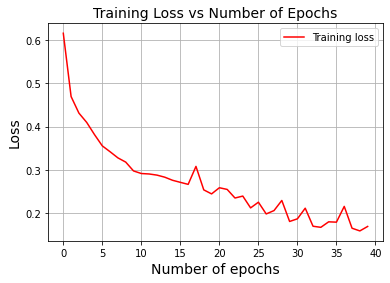

In [42]:
# One hot encoding for class labels (full training data)
y_one_hot = np.zeros((10, M + Mval))
y_one_hot[y, np.array(list(range(M+Mval)))] = 1


learned_parameters, epoch_cost = NN_best_fit(X, y_one_hot,
                            learning_rate=LEARNING_RATE,
                            activation_f = ACTIVATION,
                            init_mode = INITIALIZER,
                            optimizer = OPTIMIZER,
                            batch_size = BATCH_SIZE,
                            loss = LOSS,
                            epochs = EPOCHS,
                            L2_lamb = L2_lambda,
                            num_neurons = NUM_NEURONS,
                            num_hidden = NUM_HIDDEN)

#### Model Evaluation with X_test dataset

In [46]:
train_predictions, test_predictions = NN_evaluate(X, y, X_test, y_test, learned_parameters, ACTIVATION)

Training accuracy = 94.055 %
Test accuracy = 88.48 %
Classification report for the test set:

              precision    recall  f1-score   support

           0       0.79      0.89      0.84      1000
           1       0.99      0.97      0.98      1000
           2       0.87      0.69      0.77      1000
           3       0.87      0.92      0.89      1000
           4       0.79      0.83      0.81      1000
           5       0.98      0.97      0.97      1000
           6       0.70      0.69      0.70      1000
           7       0.96      0.95      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.94      0.97      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000



#### Confusion Matrix (Training set)

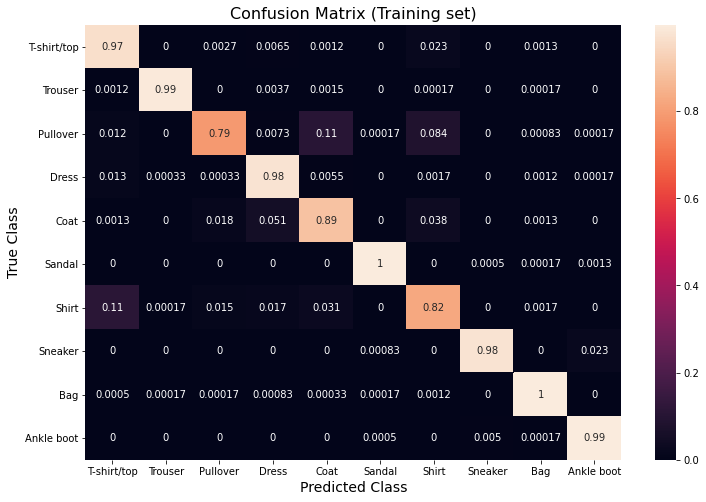

In [64]:
bern_cnf_matrix_train = confusion_matrix(y, train_predictions, normalize='true')
plt.figure(figsize=(12, 8))
ax = sns.heatmap(bern_cnf_matrix_train, annot=bern_cnf_matrix_train,xticklabels=class_names, yticklabels=class_names)
ax.set_title("Confusion Matrix (Training set)", size=16)
ax.set_xlabel("Predicted Class", size=14)
ax.set_ylabel("True Class", size=14)
plt.savefig("trainmatrix")
plt.show()

#### Confusion Matrix (Test set)

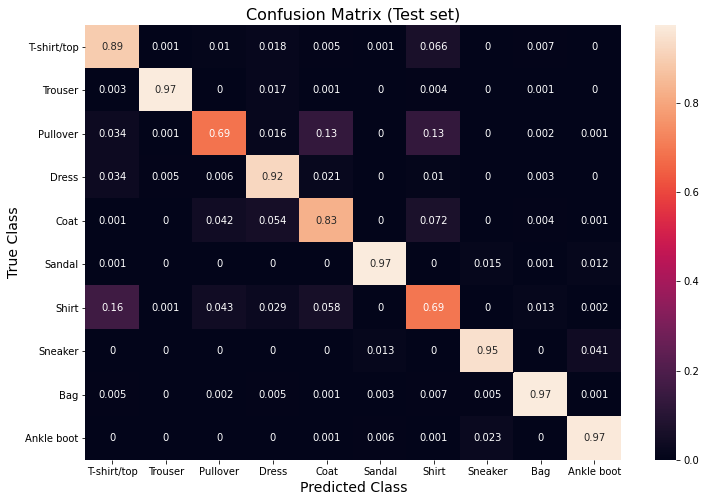

In [63]:
bern_cnf_matrix_test = confusion_matrix(y_test, test_predictions, normalize='true')
plt.figure(figsize=(12, 8))
ax = sns.heatmap(bern_cnf_matrix_test, annot=bern_cnf_matrix_test,xticklabels=class_names, yticklabels=class_names)
ax.set_title("Confusion Matrix (Test set)", size=16)
ax.set_xlabel("Predicted Class", size=14)
ax.set_ylabel("True Class", size=14)
plt.savefig("testmatrix")
plt.show()